# Group Assignment (Group 15) — Big Data
### By Matteo Ballegeer, Yaël De Rocker, Wannes Janssens, Julian Peire, Tom Willemen
#### Ghent University, Belgium
### -------------------------------------------------------------------------------------------------------------------

In this notebook, we perform EDA on our engineered features

# 1  Initialize Spark Environment

In [ ]:
%env SPARK_LOCAL_HOSTNAME=localhost

import findspark
# initialize findspark with spark directory
findspark.init("C:\Spark\spark-3.4.1-bin-hadoop3")
# import pyspark
import pyspark

from pyspark import SparkConf, SparkContext
conf = SparkConf().setMaster("local").setAppName("Test")
sc = SparkContext(conf = conf)
spark = pyspark.sql.SparkSession(sc)

In [1]:
import findspark
import pyspark
from pyspark import SparkConf, SparkContext
from pyspark import sql
from pyspark.sql import SparkSession
import sys
import os

user = "Matteo"
# Create SparkConf for the specified user
if user == "Tom":
    findspark.init("C:\Spark\spark-3.4.1-bin-hadoop3")
    config = SparkConf().setAll([
        ('spark.executor.memory', '8g'),
        ('spark.executor.cores', '10'),
        ('spark.cores.max', '8'),
        ('spark.driver.memory', '16g'),
        ('spark.network.timeout', '3600s'),
        ("spark.executor.heartbeatInterval", "3000s")
    ])
    config.setMaster("local[8]")

elif user == "Matteo":
    findspark.init("C:\Spark\spark-3.5.0-bin-hadoop3")
    config = SparkConf().setAll([
        ('spark.executor.memory', '8g'),
        ('spark.executor.cores', '4'),
        ('spark.cores.max', '4'),
        ("spark.sql.shuffle.partitions", "4"),
        ('spark.driver.memory', '8g'),
        ("spark.executor.instances", "4"),
        ('spark.network.timeout', '3600s'),
    ])
    config.setMaster("local[6]")

elif user == "Julian":
    findspark.init('C:\\Users\\jaron\\Spark\\spark-3.5.0-bin-hadoop3')
    config = SparkConf().setAll([
        ('spark.executor.memory', '8g'),
        ('spark.executor.cores', '8'),
        ('spark.cores.max', '7'),
        ('spark.driver.memory', '16g'),
        ('spark.network.timeout', '3600s'),
        ("spark.executor.heartbeatInterval", "3000s")
    ])

elif user == "Yaël":
    sql.SparkSession.builder.master("local[*]")
    config = SparkConf().setAll([
        ("spark.executor.memory", "7g"),
        ('spark.yarn.am.memory', '7g'),
        ('spark.yarn.am.cores', '8'),
        ("spark.executor.cores", "8"),
        ('spark.driver.memory', '7g'),
        ('spark.cores.max', '8')
    ])
    sys.path.append('/Users/derockeryael/Documents/Master 2/Big Data/big_data_group_15')
    config.setAppName("x").setMaster("local[8]")

elif user == "Wannes":
    findspark.init("C:\Spark\spark-3.5.0-bin-hadoop3")
    config = pyspark.SparkConf().setAll([
        ("spark.executor.memory", "8g"),
        ("spark.executor.cores", "8"),
        ('spark.driver.memory', '8g'),
        ('spark.cores.max', '8')
    ]) 
    config.setMaster("local[4]")

# # Create SparkContext using the specified SparkConf
sc = SparkContext(conf=config)

# # # Create SparkSession with the SparkContext
spark = SparkSession.builder.getOrCreate()

In [2]:
# inspect spark session
spark

In [3]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

import pyspark.sql.functions as F
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from pyspark import StorageLevel
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mtcnn import MTCNN
import os

# 2 Preprocess & Load Data

### Load in UDFs

In [4]:
# import required packages
from string import punctuation
from nltk.corpus import stopwords

# define puncutation and stopwords
PUNCTUATION = [char for char in punctuation if char not in ["!", "@", "#"]]
STOPWORDS = stopwords.words("english")

# Define function to tokenize text
def tokenize_text(text):
    return text.split(" ")

# define function to remove punctuation
def remove_punct(text):
    text = "".join([char for char in text if char not in PUNCTUATION])
    return(text)

# define function to remove stopwords
def remove_stops(text_tokenized):
    text_tokenized = [word for word in text_tokenized if word not in STOPWORDS]
    return(text_tokenized)

# register functions as udf
remove_punct_UDF = F.udf(remove_punct, StringType())
remove_stops_UDF = F.udf(remove_stops, ArrayType(StringType()))
tokenize_text_UDF = F.udf(tokenize_text, ArrayType(StringType()))

## Read-in basetable Lufthansa

In [5]:
# Specify the path to the CSV file
csv_path = "../processed_data/lufthansa/merged_basetable_luf.csv"
pandas_df = pd.read_csv(csv_path, sep=",")

# Define the schema based on the provided column types
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, ArrayType, BooleanType, DoubleType, LongType, FloatType

schema = StructType([
    StructField("post_id", StringType(), nullable=False),
    StructField("text", StringType(), nullable=True),
    StructField("text_tokenized_no_stops", StringType(), nullable=True),
    StructField("num_words", IntegerType(), nullable=False),
    StructField("num_hashtags", IntegerType(), nullable=True),
    StructField("num_tags", IntegerType(), nullable=True),
    StructField("num_exclamation_marks", IntegerType(), nullable=True),
    StructField("num_question_marks", IntegerType(), nullable=True),
    StructField("is_event", BooleanType(), nullable=True),
    StructField("sentiment", DoubleType(), nullable=True),
    StructField("subjectivity", DoubleType(), nullable=True),
    StructField("contains_link", BooleanType(), nullable=True),
    StructField("at_in_text", IntegerType(), nullable=True),
    StructField("nr_emojis", IntegerType(), nullable=True),
    StructField("num_likes", LongType(), nullable=True),
    StructField("city", StringType(), nullable=True),
    StructField("country", StringType(), nullable=True),
    StructField("location", StringType(), nullable=True),
    StructField("time", StringType(), nullable=True),
    StructField("hour", IntegerType(), nullable=True),
    StructField("ad", IntegerType(), nullable=False),
    StructField("num_pictures", IntegerType(), nullable=True),
    StructField("video", IntegerType(), nullable=False),
    StructField("location_cat", IntegerType(), nullable=False),
    StructField("aspect_ratio", DoubleType(), nullable=True),
    StructField("city_bool", StringType(), nullable=True),
    StructField("country_bool", StringType(), nullable=True),
    StructField("num_comments", LongType(), nullable=True),
    StructField("time_top_post", IntegerType(), nullable=True),
    StructField("is_weekday", BooleanType(), nullable=True),
    StructField("part_of_day", StringType(), nullable=False),
    StructField("season", StringType(), nullable=False),
    StructField("vividness", StringType(), nullable=False),
    StructField("contains_city", BooleanType(), nullable=True),
    StructField("aspect_ratio_category", StringType(), nullable=True),
    StructField("num_followers", LongType(), nullable=True),
    StructField("colorfulness", FloatType(), nullable=True),
    StructField("face_count", IntegerType(), nullable=True),
    StructField("photo_has_text", IntegerType(), nullable=True),
    StructField("has_airplane", FloatType(), nullable=True),
    StructField("has_brand_logo", IntegerType(), nullable=True)
])

In [6]:
# Convert the modified Pandas DataFrame to a PySpark DataFrame
basetable_luf = spark.createDataFrame(pandas_df, schema=schema)

In [7]:
# Show the DataFrame schema and some sample data
basetable_luf.printSchema()
basetable_luf.cache()
basetable_luf.show()

root
 |-- post_id: string (nullable = false)
 |-- text: string (nullable = true)
 |-- text_tokenized_no_stops: string (nullable = true)
 |-- num_words: integer (nullable = false)
 |-- num_hashtags: integer (nullable = true)
 |-- num_tags: integer (nullable = true)
 |-- num_exclamation_marks: integer (nullable = true)
 |-- num_question_marks: integer (nullable = true)
 |-- is_event: boolean (nullable = true)
 |-- sentiment: double (nullable = true)
 |-- subjectivity: double (nullable = true)
 |-- contains_link: boolean (nullable = true)
 |-- at_in_text: integer (nullable = true)
 |-- nr_emojis: integer (nullable = true)
 |-- num_likes: long (nullable = true)
 |-- city: string (nullable = true)
 |-- country: string (nullable = true)
 |-- location: string (nullable = true)
 |-- time: string (nullable = true)
 |-- hour: integer (nullable = true)
 |-- ad: integer (nullable = false)
 |-- num_pictures: integer (nullable = true)
 |-- video: integer (nullable = false)
 |-- location_cat: integer

In [8]:
basetable_luf = basetable_luf.na.drop(subset=["time_top_post", "num_followers"])

In [9]:
# convert features to correct data type
basetable_luf = basetable_luf.withColumn("num_words", F.col("num_words").cast(DoubleType())) \
                    .withColumn("num_hashtags", F.col("num_hashtags").cast(DoubleType())) \
                    .withColumn("num_tags", F.col("num_tags").cast(DoubleType())) \
                    .withColumn("num_exclamation_marks", F.col("num_exclamation_marks").cast(DoubleType())) \
                    .withColumn("num_question_marks", F.col("num_question_marks").cast(DoubleType())) \
                    .withColumn("is_event", F.col("is_event").cast(StringType())) \
                    .withColumn("contains_link", F.col("contains_link").cast(StringType())) \
                    .withColumn("at_in_text", F.col("at_in_text").cast(DoubleType())) \
                    .withColumn("num_likes", F.col("num_likes").cast(DoubleType())) \
                    .withColumn("hour", F.col("hour").cast(DoubleType())) \
                    .withColumn("ad", F.col("ad").cast(DoubleType())) \
                    .withColumn("num_pictures", F.col("num_pictures").cast(DoubleType())) \
                    .withColumn("video", F.col("video").cast(DoubleType())) \
                    .withColumn("is_weekday", F.col("is_weekday").cast(StringType())) \
                    .withColumn("time_top_post", F.col("time_top_post").cast(DoubleType())) \
                    .withColumn("contains_city", F.col("contains_city").cast(StringType())) \
                    .withColumn("location_cat", F.col("location_cat").cast(DoubleType()))\
                    .withColumn("num_comments", F.col("num_comments").cast(DoubleType()))\
                    .withColumn("colorfulness", F.col("colorfulness").cast(DoubleType()))\
                    .withColumn("face_count", F.col("face_count").cast(DoubleType()))\
                    .withColumn("photo_has_text", F.col("photo_has_text").cast(DoubleType()))\
                    .withColumn("has_airplane", F.col("has_airplane").cast(DoubleType()))\
                    .withColumn("has_brand_logo", F.col("has_brand_logo").cast(DoubleType()))\
                    .withColumn("nr_emojis", F.col("nr_emojis").cast(DoubleType()))

In [10]:
# add engagement column
basetable_luf = basetable_luf.withColumn('engagement', 
                                         ((F.col('num_likes') + F.col('num_comments'))/F.col('num_followers'))*100)
basetable_luf.cache()
basetable_luf.show(5)

+--------------------+--------------------+-----------------------+---------+------------+--------+---------------------+------------------+--------+---------+------------+-------------+----------+---------+---------+----+-------+--------+-------------------+----+---+------------+-----+------------+------------+---------+------------+------------+-------------+----------+-----------+------+---------+-------------+---------------------+-------------+------------------+----------+--------------+------------+--------------+------------------+
|             post_id|                text|text_tokenized_no_stops|num_words|num_hashtags|num_tags|num_exclamation_marks|num_question_marks|is_event|sentiment|subjectivity|contains_link|at_in_text|nr_emojis|num_likes|city|country|location|               time|hour| ad|num_pictures|video|location_cat|aspect_ratio|city_bool|country_bool|num_comments|time_top_post|is_weekday|part_of_day|season|vividness|contains_city|aspect_ratio_category|num_followers| 

## Read-in basetable Singapore

In [11]:
# Specify the path to the CSV file
csv_path = "../processed_data/singapore/merged_basetable_sin.csv"
pandas_df = pd.read_csv(csv_path, sep=",")

# Define the schema based on the provided column types
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, ArrayType, BooleanType, DoubleType, LongType, FloatType

schema = StructType([
    StructField("post_id", StringType(), nullable=False),
    StructField("text", StringType(), nullable=True),
    StructField("text_tokenized_no_stops", StringType(), nullable=True),
    StructField("num_words", IntegerType(), nullable=False),
    StructField("num_hashtags", IntegerType(), nullable=True),
    StructField("num_tags", IntegerType(), nullable=True),
    StructField("num_exclamation_marks", IntegerType(), nullable=True),
    StructField("num_question_marks", IntegerType(), nullable=True),
    StructField("is_event", BooleanType(), nullable=True),
    StructField("sentiment", DoubleType(), nullable=True),
    StructField("subjectivity", DoubleType(), nullable=True),
    StructField("contains_link", BooleanType(), nullable=True),
    StructField("at_in_text", IntegerType(), nullable=True),
    StructField("nr_emojis", IntegerType(), nullable=True),
    StructField("num_likes", LongType(), nullable=True),
    StructField("city", StringType(), nullable=True),
    StructField("country", StringType(), nullable=True),
    StructField("location", StringType(), nullable=True),
    StructField("time", StringType(), nullable=True),
    StructField("hour", IntegerType(), nullable=True),
    StructField("ad", IntegerType(), nullable=False),
    StructField("num_pictures", IntegerType(), nullable=True),
    StructField("video", IntegerType(), nullable=False),
    StructField("location_cat", IntegerType(), nullable=False),
    StructField("aspect_ratio", DoubleType(), nullable=True),
    StructField("city_bool", StringType(), nullable=True),
    StructField("country_bool", StringType(), nullable=True),
    StructField("num_comments", LongType(), nullable=True),
    StructField("time_top_post", IntegerType(), nullable=True),
    StructField("is_weekday", BooleanType(), nullable=True),
    StructField("part_of_day", StringType(), nullable=False),
    StructField("season", StringType(), nullable=False),
    StructField("vividness", StringType(), nullable=False),
    StructField("contains_city", BooleanType(), nullable=True),
    StructField("aspect_ratio_category", StringType(), nullable=True),
    StructField("num_followers", LongType(), nullable=True),
    StructField("colorfulness", FloatType(), nullable=True),
    StructField("face_count", IntegerType(), nullable=True),
    StructField("photo_has_text", IntegerType(), nullable=True),
    StructField("has_airplane", FloatType(), nullable=True),
    StructField("has_brand_logo", IntegerType(), nullable=True)
])

# Convert the modified Pandas DataFrame to a PySpark DataFrame
basetable_sin = spark.createDataFrame(pandas_df, schema=schema)

# Re-Create the text_tokenized_no_stops column
basetable_sin = basetable_sin.withColumn("text_lower", F.lower("text")) \
                                 .withColumn("text_cleaned", remove_punct_UDF("text_lower")) \
                                 .withColumn("text_tokenized", F.split("text_cleaned", " ")) \
                                 .withColumn("text_tokenized_no_stops", remove_stops_UDF("text_tokenized")) \
                                 .drop("text_lower") \
                                 .drop("text_cleaned") \
                                 .drop("text_tokenized")

# Show the DataFrame schema and some sample data
basetable_sin.printSchema()
basetable_sin.cache()
basetable_sin.show()

root
 |-- post_id: string (nullable = false)
 |-- text: string (nullable = true)
 |-- text_tokenized_no_stops: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- num_words: integer (nullable = false)
 |-- num_hashtags: integer (nullable = true)
 |-- num_tags: integer (nullable = true)
 |-- num_exclamation_marks: integer (nullable = true)
 |-- num_question_marks: integer (nullable = true)
 |-- is_event: boolean (nullable = true)
 |-- sentiment: double (nullable = true)
 |-- subjectivity: double (nullable = true)
 |-- contains_link: boolean (nullable = true)
 |-- at_in_text: integer (nullable = true)
 |-- nr_emojis: integer (nullable = true)
 |-- num_likes: long (nullable = true)
 |-- city: string (nullable = true)
 |-- country: string (nullable = true)
 |-- location: string (nullable = true)
 |-- time: string (nullable = true)
 |-- hour: integer (nullable = true)
 |-- ad: integer (nullable = false)
 |-- num_pictures: integer (nullable = true)
 |-- video: intege

In [12]:
# Convert features to correct data type (for eventual model building)
basetable_sin = basetable_sin.withColumn("num_words", F.col("num_words").cast(DoubleType())) \
                    .withColumn("num_hashtags", F.col("num_hashtags").cast(DoubleType())) \
                    .withColumn("num_tags", F.col("num_tags").cast(DoubleType())) \
                    .withColumn("num_exclamation_marks", F.col("num_exclamation_marks").cast(DoubleType())) \
                    .withColumn("num_question_marks", F.col("num_question_marks").cast(DoubleType())) \
                    .withColumn("is_event", F.col("is_event").cast(StringType())) \
                    .withColumn("contains_link", F.col("contains_link").cast(StringType())) \
                    .withColumn("at_in_text", F.col("at_in_text").cast(DoubleType())) \
                    .withColumn("num_likes", F.col("num_likes").cast(DoubleType())) \
                    .withColumn("hour", F.col("hour").cast(DoubleType())) \
                    .withColumn("ad", F.col("ad").cast(DoubleType())) \
                    .withColumn("num_pictures", F.col("num_pictures").cast(DoubleType())) \
                    .withColumn("video", F.col("video").cast(DoubleType())) \
                    .withColumn("is_weekday", F.col("is_weekday").cast(StringType())) \
                    .withColumn("time_top_post", F.col("time_top_post").cast(DoubleType())) \
                    .withColumn("contains_city", F.col("contains_city").cast(StringType())) \
                    .withColumn("location_cat", F.col("location_cat").cast(DoubleType()))\
                    .withColumn("num_comments", F.col("num_comments").cast(DoubleType()))\
                    .withColumn("colorfulness", F.col("colorfulness").cast(DoubleType()))\
                    .withColumn("face_count", F.col("face_count").cast(DoubleType()))\
                    .withColumn("photo_has_text", F.col("photo_has_text").cast(DoubleType()))\
                    .withColumn("has_airplane", F.col("has_airplane").cast(DoubleType()))\
                    .withColumn("has_brand_logo", F.col("has_brand_logo").cast(DoubleType()))\
                    .withColumn("nr_emojis", F.col("nr_emojis").cast(DoubleType()))

In [13]:
# add engagement column
basetable_sin = basetable_sin.withColumn('engagement', 
                                         ((F.col('num_likes') + F.col('num_comments'))/F.col('num_followers'))*100)
basetable_sin.cache()
basetable_sin.show(5)

+--------------------+--------------------+-----------------------+---------+------------+--------+---------------------+------------------+--------+---------+------------------+-------------+----------+---------+---------+----+-------+--------+-------------------+----+---+------------+-----+------------+------------------+---------+------------+------------+-------------+----------+-----------+------+---------+-------------+---------------------+-------------+------------------+----------+--------------+------------+--------------+------------------+
|             post_id|                text|text_tokenized_no_stops|num_words|num_hashtags|num_tags|num_exclamation_marks|num_question_marks|is_event|sentiment|      subjectivity|contains_link|at_in_text|nr_emojis|num_likes|city|country|location|               time|hour| ad|num_pictures|video|location_cat|      aspect_ratio|city_bool|country_bool|num_comments|time_top_post|is_weekday|part_of_day|season|vividness|contains_city|aspect_ratio_

In [14]:
# Assuming basetable_luf and basetable_sin are your DataFrames
basetable_luf = basetable_luf \
    .withColumn("post_date", to_date(substring(col("post_id"), 1, 7), "yyyy-MM")) \
    .filter(col("post_date") > lit("2016-08")) \
    .drop("post_date")

basetable_sin = basetable_sin \
    .withColumn("post_date", to_date(substring(col("post_id"), 1, 7), "yyyy-MM")) \
    .filter(col("post_date") > lit("2016-08")) \
    .drop("post_date")


# 3 EDA

In [69]:
luf_pd = basetable_luf.toPandas()
sin_pd = basetable_sin.toPandas()

#### General

In [18]:
luf_pd.head()

post_id                                               text  \
0  2016-09-01_17-58-20_UTC  Happy September! \r\nSummer is coming to a clo...   
1  2016-09-02_15-28-58_UTC  Discover a peaceful spot of your own in German...   
2  2016-09-03_22-03-49_UTC  An inflight magazine you'll want to read cover...   
3  2016-09-04_15-25-52_UTC  Bonjour Paris! \r\nPhoto by: @lieblingserinner...   
4  2016-09-05_15-58-29_UTC  What's your favorite beach to sunbathe on?\r\n...   

                             text_tokenized_no_stops  num_words  num_hashtags  \
0  ['happy', 'september!', '\r\nsummer', 'coming'...       10.0           0.0   
1  ['discover', 'peaceful', 'spot', 'germany', '\...        6.0           0.0   
2  ['inflight', 'magazine', 'youll', 'want', 'rea...        9.0           0.0   
3  ['bonjour', 'paris!', '\r\nphoto', '@lieblings...        4.0           0.0   
4  ['whats', 'favorite', 'beach', 'sunbathe', 'on...        6.0           0.0   

   num_tags  num_exclamation_marks  num_question_marks is_event  sentiment  \
0       1.0                    1.0                 0.0    false     0.6114   
1       1.0                    0.0                 0.0    false     0.4939   
2       1.0                    0.0                 0.0    false     0.0772   
3       1.0                    1.0                 0.0    false     0.0000   
4       1.0                    0.0                 0.0    false     0.4588   

   ...  vividness contains_city  aspect_ratio_category  num_followers  \
0  ...        Low         false                 square         424534   
1  ...        Low         false                 square         425281   
2  ...        Low         false              landscape         426028   
3  ...        Low         false                 square         426775   
4  ...        Low         false                 square         427522   

   colorfulness face_count photo_has_text has_airplane has_brand_logo  \
0     45.090000        0.0            0.0          0.0            0.0   
1     29.950001        0.0            0.0          0.0            0.0   
2     19.260000        0.0            1.0          0.0            1.0   
3     18.270000        0.0            0.0          0.0            0.0   
4     52.340000        0.0            0.0          0.0            0.0   

   engagement  
0    0.268530  
1    0.229730  
2    0.199048  
3    0.390135  
4    0.257063  

[5 rows x 42 columns]

In [138]:
sin_pd["post_id"] = pd.to_datetime(sin_pd["post_id"], format="%Y-%m-%d_%H-%M-%S_UTC")
luf_pd["post_id"] = pd.to_datetime(luf_pd["post_id"], format="%Y-%m-%d_%H-%M-%S_UTC")
sin_pd["year_month"] = sin_pd["post_id"].dt.to_period('M')
luf_pd["year_month"] = luf_pd["post_id"].dt.to_period('M')
sin_pd = sin_pd[sin_pd['year_month'] >= '2016-09']
luf_pd = luf_pd[luf_pd['year_month'] >= '2016-09']

In [139]:
# Descriptive statistics for Lufthansa
luf_stats = luf_pd.describe().transpose()
print("Descriptive Statistics for Lufthansa:")
print(luf_stats)

Descriptive Statistics for Lufthansa:
                        count           mean            std            min  \
num_words              1232.0      11.447240       9.314200       2.000000   
num_hashtags           1232.0       0.845779       0.870445       0.000000   
num_tags               1232.0       0.663149       0.557940       0.000000   
num_exclamation_marks  1232.0       0.286526       0.491897       0.000000   
num_question_marks     1232.0       0.000000       0.000000       0.000000   
sentiment              1232.0       0.337083       0.336542      -0.659700   
subjectivity           1232.0       0.399442       0.351180       0.000000   
at_in_text             1232.0       0.625812       0.484109       0.000000   
nr_emojis              1232.0       0.232955       0.533326       0.000000   
num_likes              1232.0    1917.115260    1596.132772     288.000000   
hour                   1232.0      15.293831       5.335505       0.000000   
ad                     123

In [140]:
# Descriptive statistics for Singapore Airlines
sin_stats = sin_pd.describe().transpose()
print("Descriptive Statistics for Singapore Airlines:")
print(sin_stats)

Descriptive Statistics for Singapore Airlines:
                        count           mean            std            min  \
num_words              1034.0      12.868472       6.786904       2.000000   
num_hashtags           1034.0       2.347195       1.221126       0.000000   
num_tags               1034.0       0.756286       0.621169       0.000000   
num_exclamation_marks  1034.0       0.363636       0.562866       0.000000   
num_question_marks     1034.0       0.000000       0.000000       0.000000   
sentiment              1034.0       0.369982       0.339349      -0.636000   
subjectivity           1034.0       0.379020       0.341536       0.000000   
at_in_text             1034.0       0.682785       0.465617       0.000000   
nr_emojis              1034.0       0.561896       0.542964       0.000000   
num_likes              1034.0   10896.604449    5395.490176    1688.000000   
hour                   1034.0      10.175048       1.872333       0.000000   
ad               

#### Sentiment & subjectivity Analysis

In [141]:
# 'text' = caption of post
luf_sentiment_df = basetable_luf.select("post_id", "text", "sentiment", "subjectivity")
sin_sentiment_df = basetable_sin.select("post_id", "text", "sentiment", "subjectivity")

# Function to calculate sentiment scores and subjectivity
def analyze_sentiment(text):
    sid = SentimentIntensityAnalyzer()
    sentiment_score = sid.polarity_scores(text)["compound"]
    subjectivity = sid.subjectivity(text)
    return sentiment_score, subjectivity

# Define the UDF
sentiment_analysis_udf = udf(analyze_sentiment, returnType=StructType([
    StructField("sentiment_score", FloatType(), True),
    StructField("subjectivity", FloatType(), True)
]))

# Apply the UDF to calculate sentiment scores and subjectivity
luf_sentiment_df = luf_sentiment_df.withColumn("sentiment_score", sentiment_analysis_udf("text"))
sin_sentiment_df = sin_sentiment_df.withColumn("sentiment_score", sentiment_analysis_udf("text"))

In [142]:
# Show the results
print("Lufthansa Sentiment Analysis Results:")
luf_sentiment_df.select("post_id", "text", "sentiment").show(truncate=False)

print("Singapore Airlines Sentiment Analysis Results:")
sin_sentiment_df.select("post_id", "text", "sentiment").show(truncate=False)

Lufthansa Sentiment Analysis Results:
+-----------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+
|post_id                |text                                                                                                                                                                                                                                                                  |sentiment|
+-----------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+
|2016-09-01_17-58-20_UTC|Happy September! \r\nSummer is coming to

In [143]:
sentiment_analysis_luf = basetable_luf.select("sentiment", "subjectivity") # on PySpark dataframes iso Pandas df
sentiment_analysis_sin = basetable_sin.select("sentiment", "subjectivity")

# Distribution of sentiment
sentiment_analysis_luf.describe().show()
sentiment_analysis_sin.describe().show()

# Average sentiment scores
avg_sentiment_luf = sentiment_analysis_luf.agg(avg("sentiment")).collect()[0][0]
avg_sentiment_sin = sentiment_analysis_sin.agg(avg("sentiment")).collect()[0][0]

print(f"Average Sentiment for Lufthansa: {avg_sentiment_luf}")
print(f"Average Sentiment for Singapore Airlines: {avg_sentiment_sin}")

+-------+-------------------+-------------------+
|summary|          sentiment|       subjectivity|
+-------+-------------------+-------------------+
|  count|               1232|               1232|
|   mean|0.33708311688311665| 0.3994423924434795|
| stddev|0.33654228734117675|0.35117971793104197|
|    min|            -0.6597|                0.0|
|    max|             0.9856|                1.0|
+-------+-------------------+-------------------+

+-------+-------------------+-------------------+
|summary|          sentiment|       subjectivity|
+-------+-------------------+-------------------+
|  count|               1034|               1034|
|   mean| 0.3699819148936169|0.37902049774168567|
| stddev|0.33934907409176696|0.34153594971963763|
|    min|             -0.636|                0.0|
|    max|             0.9868|                1.0|
+-------+-------------------+-------------------+

Average Sentiment for Lufthansa: 0.33708311688311665
Average Sentiment for Singapore Airlines: 0.3

In [144]:
# Average sentiment comparison for Pandas DataFrames
luf_avg_sentiment = luf_pd["sentiment"].mean()
sin_avg_sentiment = sin_pd["sentiment"].mean()

print(f"Average Sentiment for Lufthansa: {luf_avg_sentiment}")
print(f"Average Sentiment for Singapore Airlines: {sin_avg_sentiment}")

Average Sentiment for Lufthansa: 0.3370831168831169
Average Sentiment for Singapore Airlines: 0.36998191489361704


In [145]:
# Average subjectivity comparison
luf_avg_subjectivity = luf_pd["subjectivity"].mean()
sin_avg_subjectivity = sin_pd["subjectivity"].mean()

print(f"\nAverage Subjectivity for Lufthansa: {luf_avg_subjectivity}")
print(f"Average Subjectivity for Singapore Airlines: {sin_avg_subjectivity}")


Average Subjectivity for Lufthansa: 0.3994423924434795
Average Subjectivity for Singapore Airlines: 0.37902049774168567


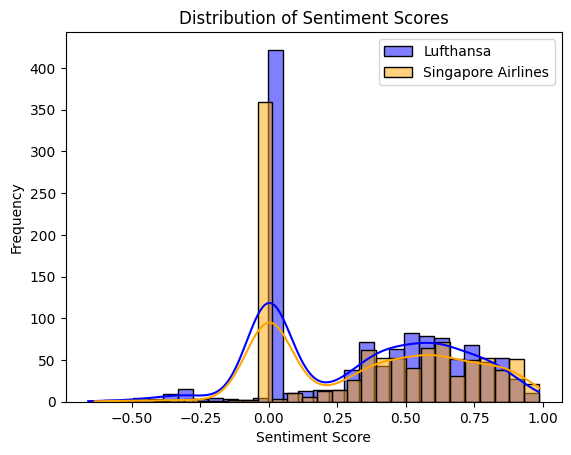

In [146]:
# Distribution of sentiment scores
sns.histplot(luf_pd["sentiment"], bins=30, kde=True, label="Lufthansa", color="blue")
sns.histplot(sin_pd["sentiment"], bins=30, kde=True, label="Singapore Airlines", color="orange")
plt.title("Distribution of Sentiment Scores")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()

#### Engagement Analysis
not using engagement-column but looking at the likes and comments

In [147]:
engagement_metrics_luf = basetable_luf.select("num_likes", "num_comments") # PySpark dataframes iso Pandas
engagement_metrics_sin = basetable_sin.select("num_likes", "num_comments")

# Summary statistics
engagement_metrics_luf.describe().show()
engagement_metrics_sin.describe().show()

# Correlation analysis
correlation_luf = engagement_metrics_luf.stat.corr("num_likes", "num_comments")
correlation_sin = engagement_metrics_sin.stat.corr("num_likes", "num_comments")

print(f"Correlation between num_likes and num_comments for Lufthansa: {correlation_luf}")
print(f"Correlation between num_likes and num_comments for Singapore Airlines: {correlation_sin}")

+-------+------------------+------------------+
|summary|         num_likes|      num_comments|
+-------+------------------+------------------+
|  count|              1232|              1232|
|   mean|1917.1152597402597|11.537337662337663|
| stddev|1596.1327720022405| 28.96834714031614|
|    min|             288.0|               1.0|
|    max|           15832.0|             715.0|
+-------+------------------+------------------+

+-------+------------------+-----------------+
|summary|         num_likes|     num_comments|
+-------+------------------+-----------------+
|  count|              1034|             1034|
|   mean|10896.604448742746|80.04061895551257|
| stddev| 5395.490175821453|93.30841911862048|
|    min|            1688.0|              2.0|
|    max|           42316.0|           1102.0|
+-------+------------------+-----------------+

Correlation between num_likes and num_comments for Lufthansa: 0.5396700900592247
Correlation between num_likes and num_comments for Singapore A

#### Text Analysis

In [70]:
text_analysis_luf = basetable_luf.select("num_words")
text_analysis_sin = basetable_sin.select("num_words")

# Average number of words
avg_words_luf = text_analysis_luf.agg(avg("num_words")).collect()[0][0]
avg_words_sin = text_analysis_sin.agg(avg("num_words")).collect()[0][0]

print(f"Average Number of Words for Lufthansa: {avg_words_luf}")
print(f"Average Number of Words for Singapore Airlines: {avg_words_sin}")

Average Number of Words for Lufthansa: 11.44724025974026
Average Number of Words for Singapore Airlines: 12.868471953578336


##### Events mentioned in text

In [16]:
df_luf_event= basetable_luf.select("is_event","engagement")
df_sin_event = basetable_sin.select("is_event","engagement")

In [17]:
# Count the occurrences of 'true' in the is_event column for each DataFrame
luf_true_count = df_luf_event[df_luf_event['is_event'] == True].count()
sin_true_count = df_sin_event[df_sin_event['is_event'] == True].count()

# Calculate the total number of rows in each DataFrame
total_luf_count = df_luf_event.count()
total_sin_count = df_sin_event.count()

# Calculate the percentage frequency of 'true' in the is_event column for each DataFrame
luf_percentage = (luf_true_count / total_luf_count) * 100
sin_percentage = (sin_true_count / total_sin_count) * 100

# Print the results
print("Percentage Frequency of 'True' in the is_event column:")
print(f"Lufthansa: {luf_percentage:.2f}%")
print(f"Singapore Airlines: {sin_percentage:.2f}%")

Percentage Frequency of 'True' in the is_event column:
Lufthansa: 0.41%
Singapore Airlines: 0.58%


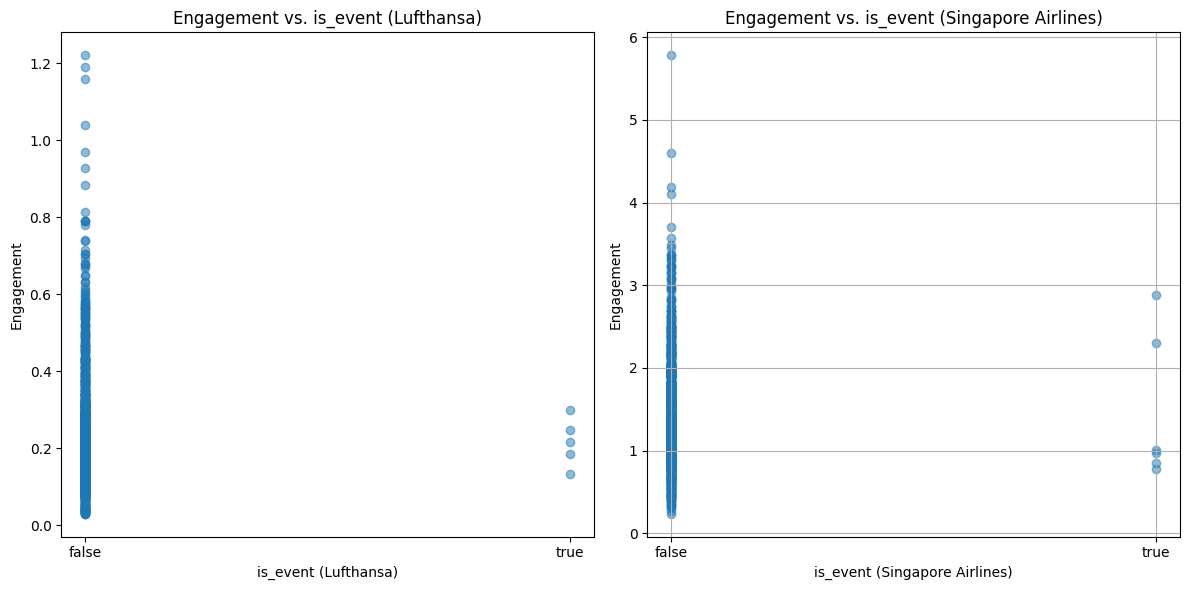

In [26]:
import matplotlib.pyplot as plt

# Assuming you already have the DataFrames df_luf_event and df_sin_event

# Create separate plots for Lufthansa and Singapore Airlines
plt.figure(figsize=(12, 6))

# Plot for Lufthansa
plt.subplot(1, 2, 1)
plt.scatter(df_luf_event.toPandas()['is_event'], df_luf_event.toPandas()['engagement'], alpha=0.5)
plt.xlabel('is_event (Lufthansa)')
plt.ylabel('Engagement')
plt.title('Engagement vs. is_event (Lufthansa)')

# Plot for Singapore Airlines
plt.subplot(1, 2, 2)
plt.scatter(df_sin_event.toPandas()['is_event'], df_sin_event.toPandas()['engagement'], alpha=0.5)
plt.xlabel('is_event (Singapore Airlines)')
plt.ylabel('Engagement')
plt.title('Engagement vs. is_event (Singapore Airlines)')

# Adjust layout
plt.tight_layout()


# Show the plots
plt.show()


##### Emojis in text

In [18]:
df_luf_emoji= basetable_luf.select("nr_emojis","engagement")
df_sin_emoji = basetable_sin.select("nr_emojis","engagement")

In [19]:
# Calculate the average and standard deviation of nr_emojis for Lufthansa
luf_avg_stddev_df = df_luf_emoji.select(avg("nr_emojis").alias("avg_nr_emojis_luf"), F.stddev("nr_emojis").alias("stddev_nr_emojis_luf"))

# Calculate the average and standard deviation of nr_emojis for Singapore Airlines
sin_avg_stddev_df = df_sin_emoji.select(avg("nr_emojis").alias("avg_nr_emojis_sin"), F.stddev("nr_emojis").alias("stddev_nr_emojis_sin"))

# Show the results for Lufthansa
print("Lufthansa:")
luf_avg_stddev_df.show()

# Show the results for Singapore Airlines
print("Singapore Airlines:")
sin_avg_stddev_df.show()

Lufthansa:
+-------------------+--------------------+
|  avg_nr_emojis_luf|stddev_nr_emojis_luf|
+-------------------+--------------------+
|0.23295454545454544|  0.5333264291025914|
+-------------------+--------------------+

Singapore Airlines:
+------------------+--------------------+
| avg_nr_emojis_sin|stddev_nr_emojis_sin|
+------------------+--------------------+
|0.5618955512572534|  0.5429640468447761|
+------------------+--------------------+



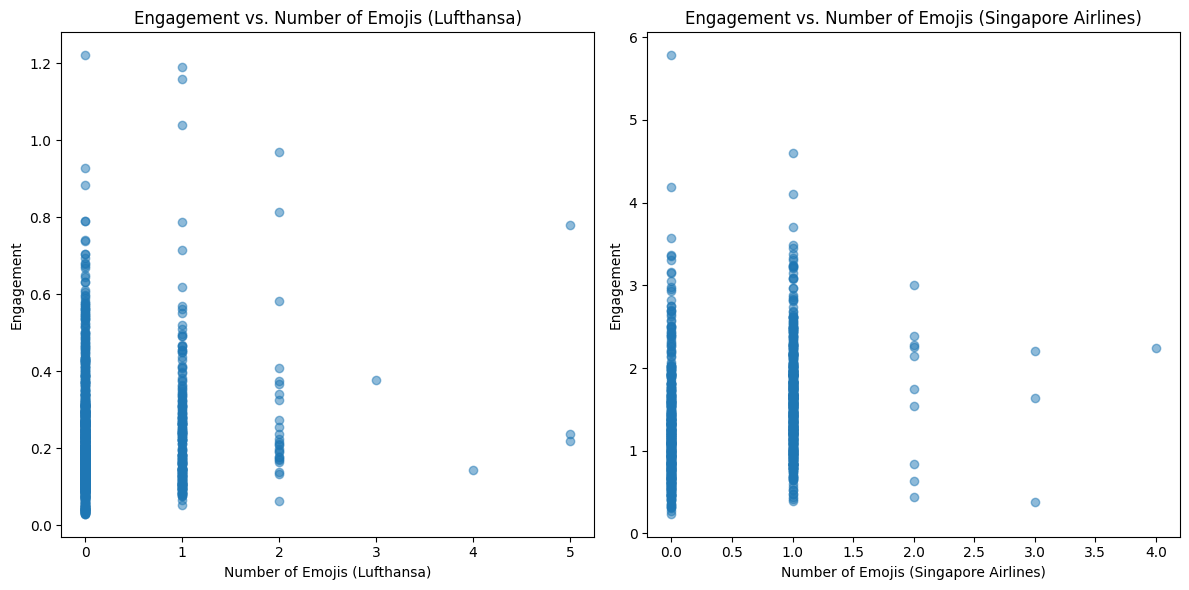

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you already have the DataFrames df_luf_emoji and df_sin_emoji

# Convert the Spark DataFrames to Pandas DataFrames for plotting
luf_pd = df_luf_emoji.toPandas()
sin_pd = df_sin_emoji.toPandas()

# Create scatterplots for Lufthansa
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(luf_pd['nr_emojis'], luf_pd['engagement'], alpha=0.5)
plt.xlabel('Number of Emojis (Lufthansa)')
plt.ylabel('Engagement')
plt.title('Engagement vs. Number of Emojis (Lufthansa)')

# Create scatterplots for Singapore Airlines
plt.subplot(1, 2, 2)
plt.scatter(sin_pd['nr_emojis'], sin_pd['engagement'], alpha=0.5)
plt.xlabel('Number of Emojis (Singapore Airlines)')
plt.ylabel('Engagement')
plt.title('Engagement vs. Number of Emojis (Singapore Airlines)')

# Adjust layout
plt.tight_layout()

# Show the scatterplots
plt.show()


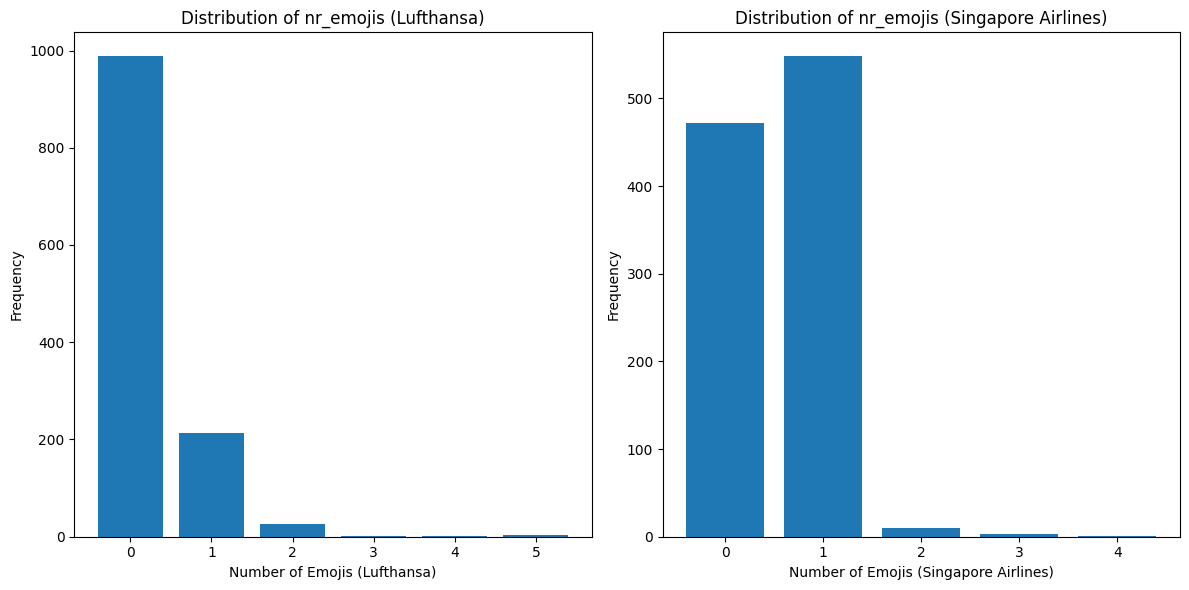

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you already have the DataFrames df_luf_emoji and df_sin_emoji

# Convert the Spark DataFrames to Pandas DataFrames for plotting
luf_pd = df_luf_emoji.toPandas()
sin_pd = df_sin_emoji.toPandas()

# Create a bar chart for Lufthansa
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
luf_nr_emojis_counts = luf_pd['nr_emojis'].value_counts().sort_index()
plt.bar(luf_nr_emojis_counts.index, luf_nr_emojis_counts.values)
plt.xlabel('Number of Emojis (Lufthansa)')
plt.ylabel('Frequency')
plt.title('Distribution of nr_emojis (Lufthansa)')

# Create a bar chart for Singapore Airlines
plt.subplot(1, 2, 2)
sin_nr_emojis_counts = sin_pd['nr_emojis'].value_counts().sort_index()
plt.bar(sin_nr_emojis_counts.index, sin_nr_emojis_counts.values)
plt.xlabel('Number of Emojis (Singapore Airlines)')
plt.ylabel('Frequency')
plt.title('Distribution of nr_emojis (Singapore Airlines)')

# Adjust layout
plt.tight_layout()

# Show the bar charts
plt.show()


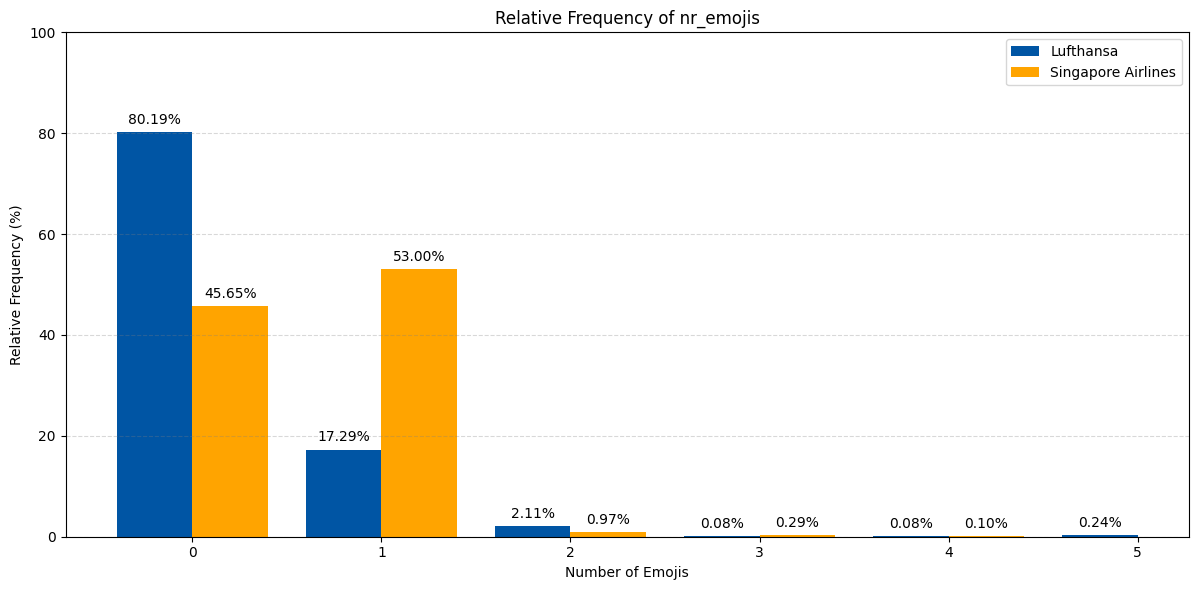

In [31]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the Spark DataFrames to Pandas DataFrames for plotting
luf_pd = df_luf_emoji.toPandas()
sin_pd = df_sin_emoji.toPandas()

# Calculate the relative frequency for Lufthansa
luf_nr_emojis_counts = luf_pd['nr_emojis'].value_counts().sort_index()
luf_relative_freq = luf_nr_emojis_counts / luf_nr_emojis_counts.sum()

# Calculate the relative frequency for Singapore Airlines
sin_nr_emojis_counts = sin_pd['nr_emojis'].value_counts().sort_index()
sin_relative_freq = sin_nr_emojis_counts / sin_nr_emojis_counts.sum()

# Create a single bar chart for both airlines
plt.figure(figsize=(12, 6))

# Define custom colors
color_luf = '#0055A4'  # Lufthansa blue
color_sin = '#FFA400'  # Singapore Airlines orange

# Plot for basetable_luf with custom color
plt.bar(luf_relative_freq.index - 0.2, luf_relative_freq.values * 100, width=0.4, label='Lufthansa', align='center', color=color_luf)

# Plot for basetable_sin with custom color
plt.bar(sin_relative_freq.index + 0.2, sin_relative_freq.values * 100, width=0.4, label='Singapore Airlines', align='center', color=color_sin)

plt.xlabel('Number of Emojis')
plt.ylabel('Relative Frequency (%)')
plt.title('Relative Frequency of nr_emojis')

# Add values to the bars
for x, y in zip(luf_relative_freq.index, luf_relative_freq.values * 100):
    plt.text(x - 0.2, y + 1, f'{y:.2f}%', ha='center', va='bottom', color='black')

for x, y in zip(sin_relative_freq.index, sin_relative_freq.values * 100):
    plt.text(x + 0.2, y + 1, f'{y:.2f}%', ha='center', va='bottom', color='black')

plt.tight_layout()
plt.legend()

# Set y-axis limits to 0% to 100%
plt.ylim(0, 100)

# Customize grid lines (subtle and grey)
plt.grid(True, axis='y', linestyle='--', alpha=0.3, color='gray')

# Show the bar chart
plt.show()


#### Image analysis

In [20]:
# Which images have an airplane but no logo?
df_airplane_no_logo_luf= basetable_luf.filter((basetable_luf["has_airplane"] == 1) & (basetable_luf["has_brand_logo"] == 0))

df_airplane_no_logo_sin= basetable_sin.filter((basetable_sin["has_airplane"] == 1) & (basetable_sin["has_brand_logo"] == 0))

# conclusion the google logo_detection API made some mistakes, i.e. not recognizing a label when one is present. 

../data/singaporeair/2017-08-16_08-36-39_UTC.jpg


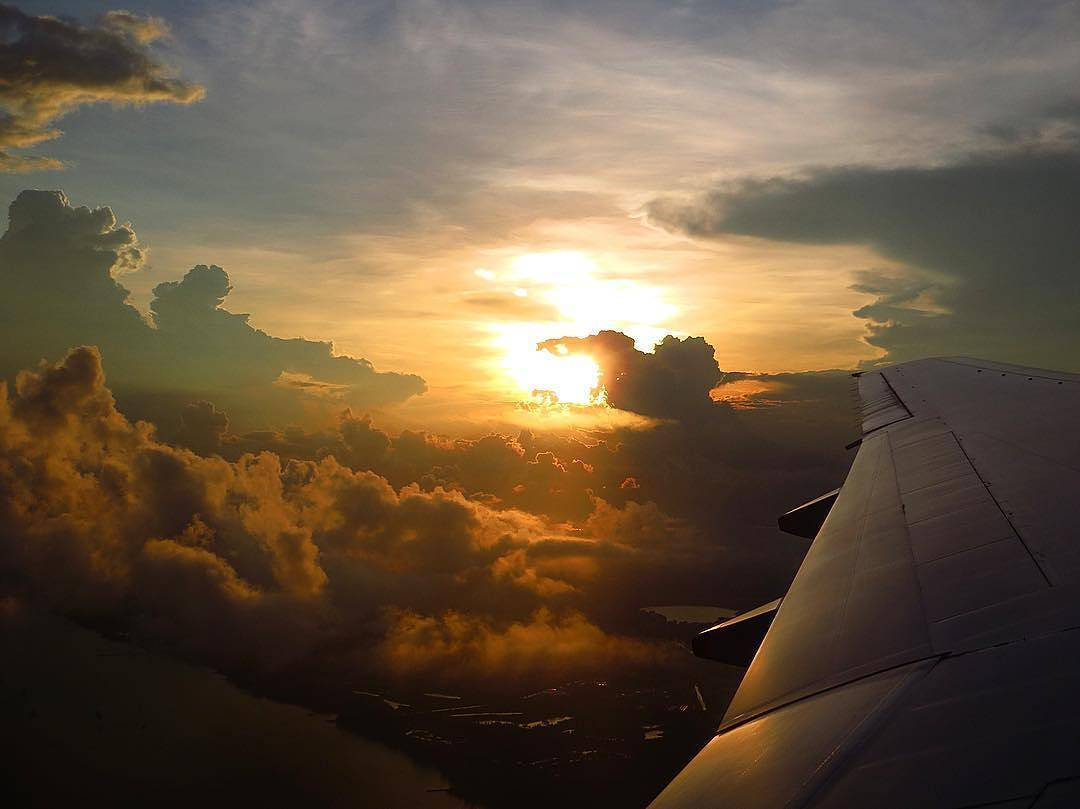

../data/singaporeair/2018-09-01_09-32-46_UTC.jpg


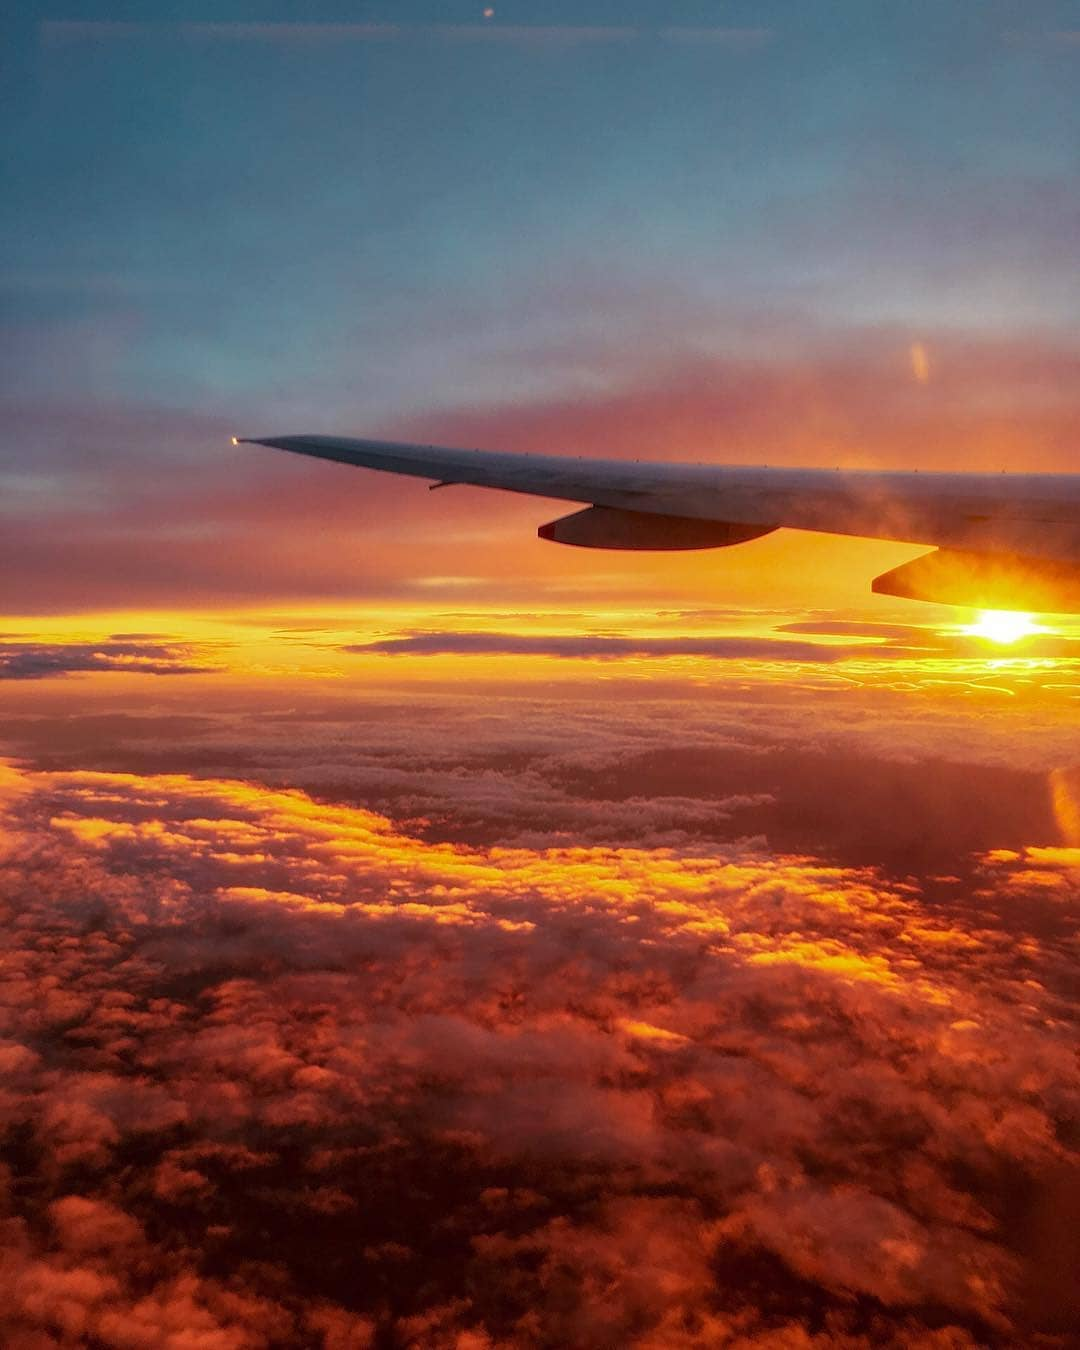

../data/lufthansa_usa/2016-09-07_16-25-09_UTC.jpg


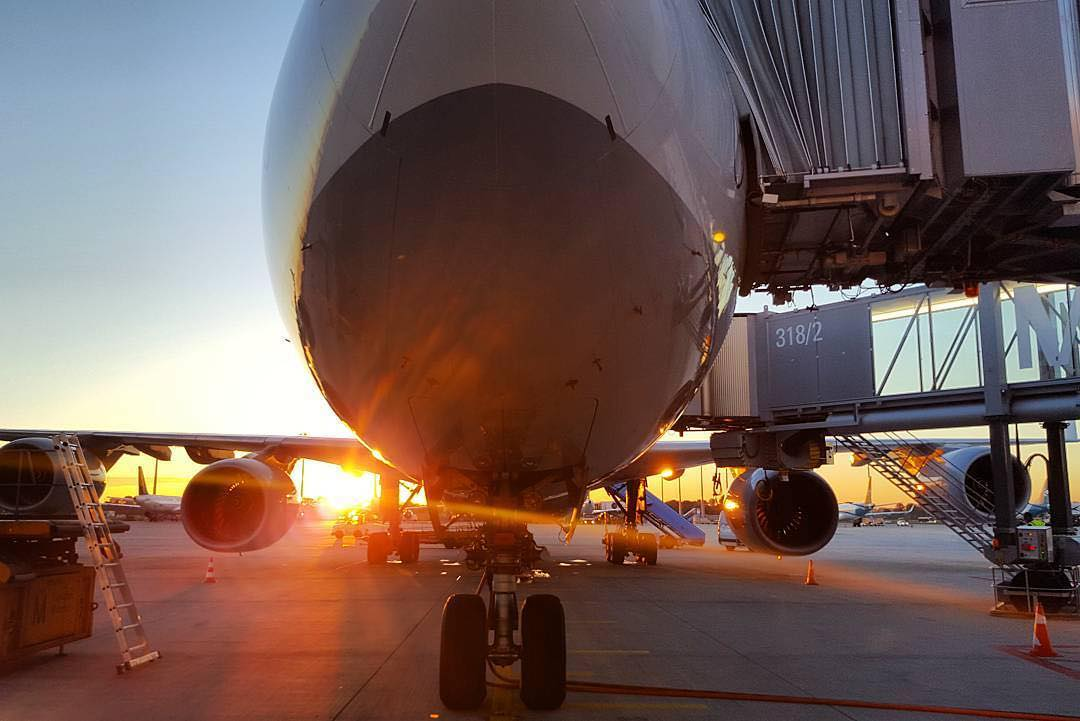

../data/lufthansa_usa/2016-09-18_19-06-34_UTC.jpg


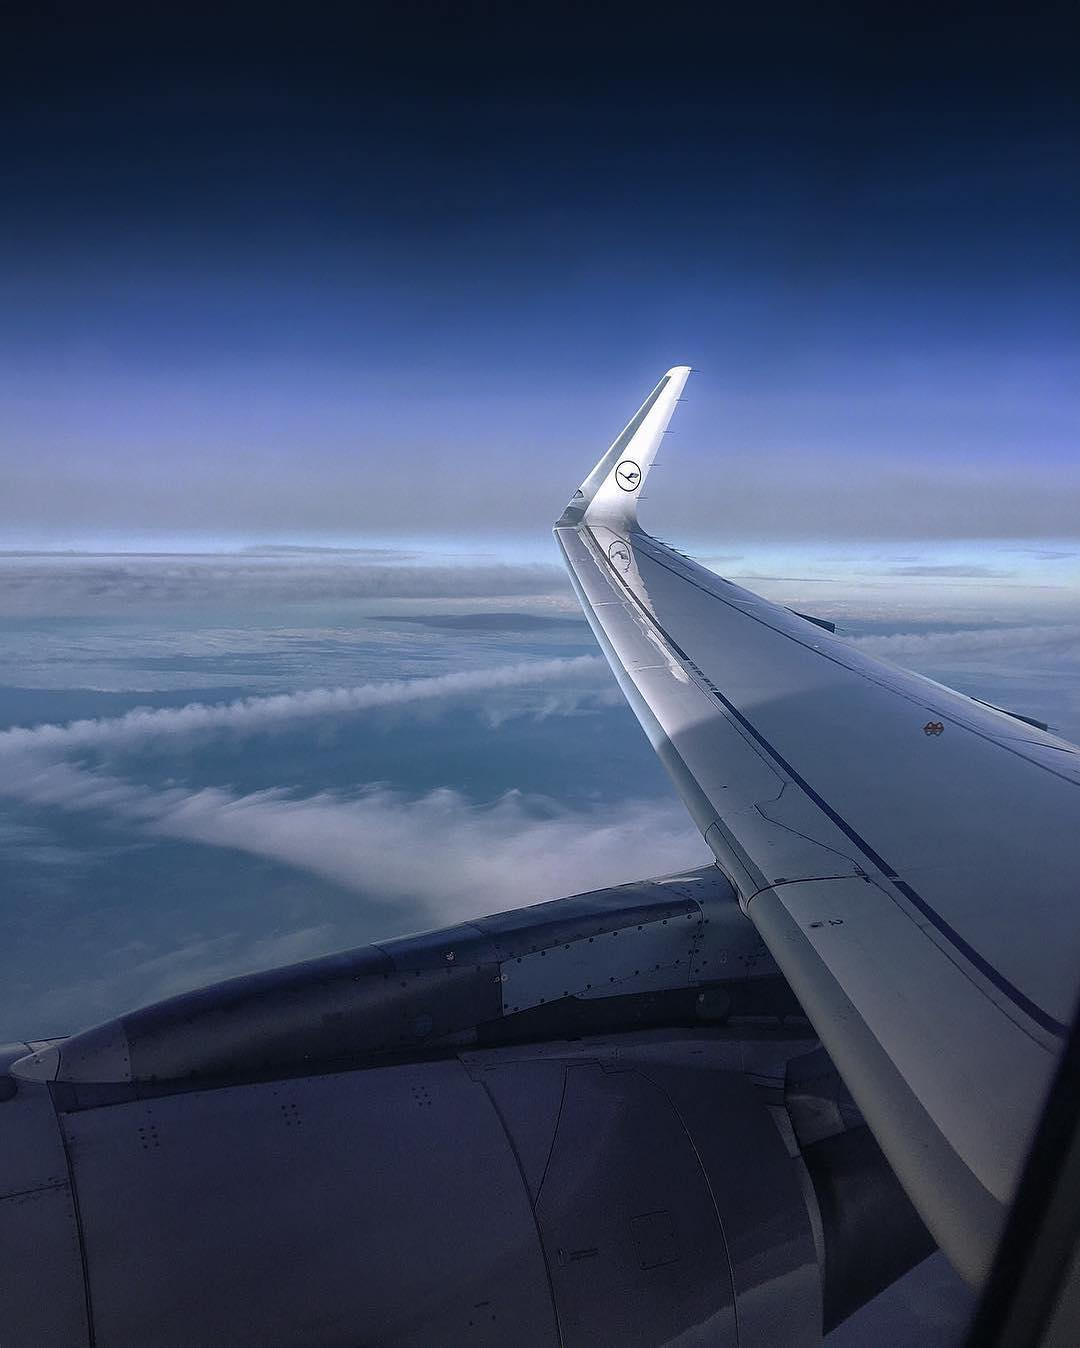

In [27]:
import os
from PIL import Image
from IPython.display import display  # Import the display function


# Define the path to the folder containing the images
start_path = ["../data/singaporeair/","../data/lufthansa_usa/"]
dataframes=[df_airplane_no_logo_sin, df_airplane_no_logo_luf]
end_path = ".jpg"
for i in range(len(start_path)):
    path= start_path[i]
    df= dataframes[i]

    # Assuming you have a DataFrame named "df_airplane_no_logo_luf" containing the "post_id" column
    # Iterate through the rows of the DataFrame and display each image
    for row in df.collect()[0:2]:
        post_id = row["post_id"] + ".jpg"
        # Construct the complete file path
        image_path = os.path.join(path, post_id)
        print(image_path)
        
        # Check if the file exists
        if os.path.exists(image_path):
            # Open the image using PIL
            image = Image.open(image_path)
            # Display the image in the notebook
            display(image)
        else:
            print(f"Image not found for post_id: {post_id}")


# 4 Important features EDA

#### has_airplane

In [154]:
airplanes_luf = basetable_luf.agg(F.avg('has_airplane').alias('airplanes_luf')).collect()[0]['airplanes_luf']
airplanes_sin = basetable_sin.agg(F.avg('has_airplane').alias('airplanes_sin')).collect()[0]['airplanes_sin']
# Print percentages
print(f"Number of posts containing an airplane for basetable_luf: {airplanes_luf}")
print(f"Number of posts containing an airplane for basetable_sin: {airplanes_sin}")


# Calculate average engagement for basetable_luf and basetable_sin
avg_engagement_luf = basetable_luf.agg(F.avg('engagement').alias('avg_engagement_luf')).collect()[0]['avg_engagement_luf']
avg_engagement_sin = basetable_sin.agg(F.avg('engagement').alias('avg_engagement_sin')).collect()[0]['avg_engagement_sin']

# Print average engagement scores
print(f"Average engagement score for basetable_luf: {avg_engagement_luf}")
print(f"Average engagement score for basetable_sin: {avg_engagement_sin}")

Number of posts containing an airplane for basetable_luf: 0.22077922077922077
Number of posts containing an airplane for basetable_sin: 0.3346228239845261
Average engagement score for basetable_luf: 0.22432685844479539
Average engagement score for basetable_sin: 1.4705705522555699


In [151]:
# calculate the avg engagement when there is an airplane present in the photo
grouped_airplane_luf = basetable_luf.filter(F.col('video') == 0)
grouped_airplane_luf = basetable_luf.groupBy('has_airplane').agg(
    F.avg(F.col('engagement')).alias('avg_engagement_luf'),
    F.stddev(F.col('engagement')).alias('stddev_engagement_luf')
)

grouped_airplane_luf.cache()
grouped_airplane_luf.show(5)


grouped_airplane_sin = basetable_sin.filter(F.col('video') == 0)
grouped_airplane_sin = basetable_sin.groupBy('has_airplane').agg(
    F.avg(F.col('engagement')).alias('avg_engagement_sin'),
    F.stddev(F.col('engagement')).alias('stddev_engagement_sin')
)

grouped_airplane_sin.cache()
grouped_airplane_sin.show(5)

+------------+-------------------+---------------------+
|has_airplane| avg_engagement_luf|stddev_engagement_luf|
+------------+-------------------+---------------------+
|         0.0|0.17606660514564093|  0.09118281581884255|
|         1.0|0.39465716420651686|  0.17477972237389156|
+------------+-------------------+---------------------+

+------------+------------------+---------------------+
|has_airplane|avg_engagement_sin|stddev_engagement_sin|
+------------+------------------+---------------------+
|         0.0|1.2556111395249407|   0.5894178328671674|
|         1.0|1.8980042978008669|     0.57018693939061|
+------------+------------------+---------------------+



Engagement more than twice as high for lufthansa when an airplane in the picture, 50% higher for singaporeair

#### country_bool   

In [44]:
# Grouping and calculating metrics for basetable_luf
grouped_country_luf = basetable_luf.groupBy('country_bool').agg(
    F.avg(col('engagement')).alias('avg_engagement_luf'),
    F.stddev(col('engagement')).alias('stddev_engagement_luf'),
    avg(col('num_likes')).alias('avg_num_likes_luf'),
    avg(col('num_comments')).alias('avg_num_comments_luf')
)

# Grouping and calculating metrics for basetable_sin
grouped_country_sin = basetable_sin.groupBy('country_bool').agg(
    avg(col('engagement')).alias('avg_engagement_sin'),
    F.stddev(col('engagement')).alias('stddev_engagement_sin'),
    avg(col('num_likes')).alias('avg_num_likes_sin'),
    avg(col('num_comments')).alias('avg_num_comments_sin')
)

# Show results for basetable_luf and basetable_sin
grouped_country_luf.cache()
grouped_country_sin.cache()
grouped_country_luf.show()
grouped_country_sin.show()

+------------+-------------------+---------------------+------------------+--------------------+
|country_bool| avg_engagement_luf|stddev_engagement_luf| avg_num_likes_luf|avg_num_comments_luf|
+------------+-------------------+---------------------+------------------+--------------------+
|           0| 0.4287290769246571|  0.40903819470860725|1583.3029721955897|  10.923298178331736|
|           1|0.20226264312707823|  0.10872013916543477|1589.7214484679666|   8.520891364902507|
+------------+-------------------+---------------------+------------------+--------------------+

+------------+------------------+---------------------+------------------+--------------------+
|country_bool|avg_engagement_sin|stddev_engagement_sin| avg_num_likes_sin|avg_num_comments_sin|
+------------+------------------+---------------------+------------------+--------------------+
|           0|2.2883087479785957|   1.9075880950978001|8007.2709640616085|   65.75128351397603|
|           1|2.8445078228073686|

#### city_bool  

In [45]:
# Grouping and calculating metrics for basetable_luf by 'city_bool'
grouped_city_luf = basetable_luf.groupBy('city_bool').agg(
    F.avg(col('engagement')).alias('avg_engagement_luf'),
    F.stddev(col('engagement')).alias('stddev_engagement_luf'),
    avg(col('num_likes')).alias('avg_num_likes_luf'),
    avg(col('num_comments')).alias('avg_num_comments_luf')
)

# Grouping and calculating metrics for basetable_sin by 'city_bool'
grouped_city_sin = basetable_sin.groupBy('city_bool').agg(
    avg(col('engagement')).alias('avg_engagement_sin'),
    F.stddev(col('engagement')).alias('stddev_engagement_sin'),
    avg(col('num_likes')).alias('avg_num_likes_sin'),
    avg(col('num_comments')).alias('avg_num_comments_sin')
)

# Show results for basetable_luf and basetable_sin grouped by 'city_bool'
grouped_city_luf.cache()
grouped_city_sin.cache()
grouped_city_luf.show()
grouped_city_sin.show()

+---------+-------------------+---------------------+------------------+--------------------+
|city_bool| avg_engagement_luf|stddev_engagement_luf| avg_num_likes_luf|avg_num_comments_luf|
+---------+-------------------+---------------------+------------------+--------------------+
|        0| 0.4287290769246571|  0.40903819470860725|1583.3029721955897|  10.923298178331736|
|        1|0.20226264312707823|  0.10872013916543477|1589.7214484679666|   8.520891364902507|
+---------+-------------------+---------------------+------------------+--------------------+

+---------+------------------+---------------------+------------------+--------------------+
|city_bool|avg_engagement_sin|stddev_engagement_sin| avg_num_likes_sin|avg_num_comments_sin|
+---------+------------------+---------------------+------------------+--------------------+
|        0|2.2883087479785957|   1.9075880950978001|8007.2709640616085|   65.75128351397603|
|        1|2.8445078228073686|    1.915070571072413|           

#### location_cat

In [46]:
# Grouping and calculating metrics for basetable_luf by 'location_cat'
grouped_location_luf = basetable_luf.groupBy('location_cat').agg(
    F.avg(col('engagement')).alias('avg_engagement_luf'),
    F.stddev(col('engagement')).alias('stddev_engagement_luf'),
    avg(col('num_likes')).alias('avg_num_likes_luf'),
    avg(col('num_comments')).alias('avg_num_comments_luf')
)

# Grouping and calculating metrics for basetable_sin by 'location_cat'
grouped_location_sin = basetable_sin.groupBy('location_cat').agg(
    avg(col('engagement')).alias('avg_engagement_sin'),
    F.stddev(col('engagement')).alias('stddev_engagement_sin'),
    avg(col('num_likes')).alias('avg_num_likes_sin'),
    avg(col('num_comments')).alias('avg_num_comments_sin')
)

# Show results for basetable_luf and basetable_sin grouped by 'location_cat'
grouped_location_luf.cache()
grouped_location_sin.cache()
grouped_location_luf.show()
grouped_location_sin.show()

+------------+-------------------+---------------------+------------------+--------------------+
|location_cat| avg_engagement_luf|stddev_engagement_luf| avg_num_likes_luf|avg_num_comments_luf|
+------------+-------------------+---------------------+------------------+--------------------+
|         0.0| 0.4287290769246571|  0.40903819470860725|1583.3029721955897|  10.923298178331736|
|         1.0|0.20226264312707823|  0.10872013916543477|1589.7214484679666|   8.520891364902507|
+------------+-------------------+---------------------+------------------+--------------------+

+------------+------------------+---------------------+------------------+--------------------+
|location_cat|avg_engagement_sin|stddev_engagement_sin| avg_num_likes_sin|avg_num_comments_sin|
+------------+------------------+---------------------+------------------+--------------------+
|         0.0|2.2883087479785957|   1.9075880950978001|8007.2709640616085|   65.75128351397603|
|         1.0|2.8445078228073686|

#### has_brand_logo

In [157]:
logo_luf = basetable_luf.agg(F.avg('has_brand_logo').alias('logo_luf')).collect()[0]['logo_luf']
logo_sin = basetable_sin.agg(F.avg('has_brand_logo').alias('logo_sin')).collect()[0]['logo_sin']
# Print percentages
print(f"Number of posts containing logo for basetable_luf: {logo_luf}")
print(f"Number of posts containing logo for basetable_sin: {logo_sin}")

# Grouping and calculating metrics for basetable_luf by 'has_brand_logo'
grouped_brand_luf = basetable_luf.groupBy('has_brand_logo').agg(
    F.avg(col('engagement')).alias('avg_engagement_luf'),
    F.stddev(col('engagement')).alias('stddev_engagement_luf'),
    avg(col('num_likes')).alias('avg_num_likes_luf'),
    avg(col('num_comments')).alias('avg_num_comments_luf')
)

# Grouping and calculating metrics for basetable_sin by 'has_brand_logo'
grouped_brand_sin = basetable_sin.groupBy('has_brand_logo').agg(
    avg(col('engagement')).alias('avg_engagement_sin'),
    F.stddev(col('engagement')).alias('stddev_engagement_sin'),
    avg(col('num_likes')).alias('avg_num_likes_sin'),
    avg(col('num_comments')).alias('avg_num_comments_sin')
)

# Show results for basetable_luf and basetable_sin grouped by 'has_brand_logo'
grouped_brand_luf.cache()
grouped_brand_sin.cache()
grouped_brand_luf.show()
grouped_brand_sin.show()

Number of posts containing logo for basetable_luf: 0.10633116883116883
Number of posts containing logo for basetable_sin: 0.12959381044487428
+--------------+-------------------+---------------------+------------------+--------------------+
|has_brand_logo| avg_engagement_luf|stddev_engagement_luf| avg_num_likes_luf|avg_num_comments_luf|
+--------------+-------------------+---------------------+------------------+--------------------+
|           0.0|0.20255152545971417|  0.12182996474010101|1656.2942779291552|   9.061762034514079|
|           1.0| 0.4073393898690274|   0.1988944540059961| 4109.206106870229|  32.343511450381676|
+--------------+-------------------+---------------------+------------------+--------------------+

+--------------+------------------+---------------------+------------------+--------------------+
|has_brand_logo|avg_engagement_sin|stddev_engagement_sin| avg_num_likes_sin|avg_num_comments_sin|
+--------------+------------------+---------------------+----------

#### aspect_ratio

In [160]:
basetable_luf.filter("post_id == '2020-11-04_16-17-11_UTC'").select("post_id", col("has_airplane"), col("has_brand_logo")).show()

+--------------------+------------+--------------+
|             post_id|has_airplane|has_brand_logo|
+--------------------+------------+--------------+
|2020-11-04_16-17-...|         1.0|           1.0|
+--------------------+------------+--------------+



In [48]:
# Grouping and calculating metrics for basetable_luf by 'aspect_ratio'
grouped_ratio_luf = basetable_luf.groupBy('aspect_ratio_category').agg(
    F.avg(col('engagement')).alias('avg_engagement_luf'),
    F.stddev(col('engagement')).alias('stddev_engagement_luf'),
    avg(col('num_likes')).alias('avg_num_likes_luf'),
    avg(col('num_comments')).alias('avg_num_comments_luf')
)

# Grouping and calculating metrics for basetable_sin by 'aspect_ratio'
grouped_ratio_sin = basetable_sin.groupBy('aspect_ratio_category').agg(
    avg(col('engagement')).alias('avg_engagement_sin'),
    F.stddev(col('engagement')).alias('stddev_engagement_sin'),
    avg(col('num_likes')).alias('avg_num_likes_sin'),
    avg(col('num_comments')).alias('avg_num_comments_sin')
)

# Show results for basetable_luf and basetable_sin grouped by 'aspect_ratio'
grouped_ratio_luf.cache()
grouped_ratio_sin.cache()
grouped_ratio_luf.show()
grouped_ratio_sin.show()

+---------------------+-------------------+---------------------+------------------+--------------------+
|aspect_ratio_category| avg_engagement_luf|stddev_engagement_luf| avg_num_likes_luf|avg_num_comments_luf|
+---------------------+-------------------+---------------------+------------------+--------------------+
|            landscape|0.22991894423782086|  0.13486418403158257|1403.0051020408164|   6.926020408163265|
|               square|0.43528787832158167|   0.4353323980001546|1551.7677984665936|   11.94633077765608|
|             portrait|0.22991874111585447|  0.11609823908091926|1811.5416666666667|   8.528508771929825|
+---------------------+-------------------+---------------------+------------------+--------------------+

+---------------------+------------------+---------------------+------------------+--------------------+
|aspect_ratio_category|avg_engagement_sin|stddev_engagement_sin| avg_num_likes_sin|avg_num_comments_sin|
+---------------------+------------------+-----

#### num_words

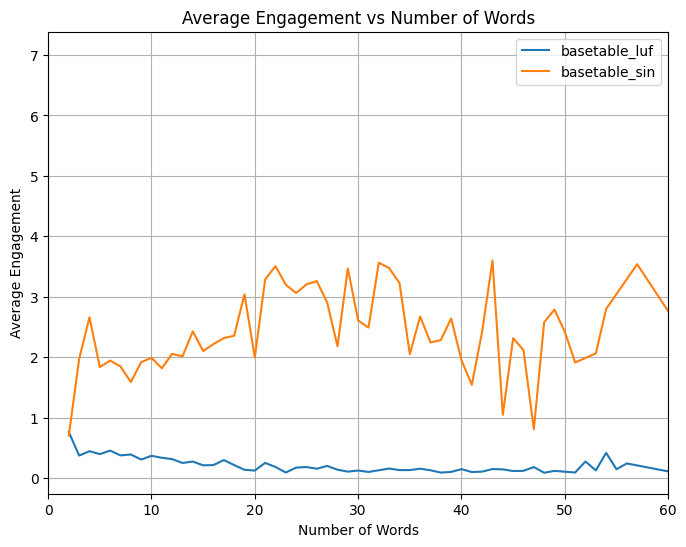

In [49]:
# Grouping and calculating metrics for basetable_luf by 'num_words'
grouped_num_words_luf = basetable_luf.groupBy('num_words').agg(
    F.avg('engagement').alias('avg_engagement_luf')
).orderBy('num_words')

# Grouping and calculating metrics for basetable_sin by 'num_words'
grouped_num_words_sin = basetable_sin.groupBy('num_words').agg(
    F.avg('engagement').alias('avg_engagement_sin')
).orderBy('num_words')

# Convert Spark DataFrames to Pandas DataFrames
df_luf = grouped_num_words_luf.toPandas()
df_sin = grouped_num_words_sin.toPandas()

# Plotting the data from Pandas DataFrames
plt.figure(figsize=(8, 6))
plt.plot(df_luf['num_words'], df_luf['avg_engagement_luf'], label='basetable_luf')
plt.plot(df_sin['num_words'], df_sin['avg_engagement_sin'], label='basetable_sin')
plt.xlabel('Number of Words')
plt.ylabel('Average Engagement')
plt.title('Average Engagement vs Number of Words')
plt.legend()
plt.xlim(0,60)
plt.grid(True)
plt.show()

In [51]:
from pyspark.ml.feature import Bucketizer
from pyspark.sql import functions as F

# Define bucket boundaries
bucketizer = Bucketizer(splits=[float('-inf'), 10, 20, 30, 40, 50, float('inf')],
                        inputCol='num_words', outputCol='word_buckets')

# Bucketizing 'num_words' column into buckets
basetable_luf_bucketed = bucketizer.transform(basetable_luf)

# Group by 'word_buckets' and calculate average and standard deviation of 'engagement'
avg_stddev_df = basetable_luf_bucketed.groupBy('word_buckets').agg(
    F.avg('engagement').alias('avg_engagement'),
    F.stddev('engagement').alias('sttdev_engagement')
).sort('word_buckets')

# Show the computed averages and standard deviations for each bucket
avg_stddev_df.show()

+------------+-------------------+-------------------+
|word_buckets|     avg_engagement|  sttdev_engagement|
+------------+-------------------+-------------------+
|         0.0|  0.388515727055061|0.36724435202970357|
|         1.0|0.29375611360211334| 0.3089378431256781|
|         2.0|0.15773505007226313|0.12888980193143484|
|         3.0|0.12402940319080254|0.06427582790448638|
|         4.0|0.12819353537480127|0.05682376647351601|
|         5.0| 0.2101686132691837|0.12819892398401095|
+------------+-------------------+-------------------+



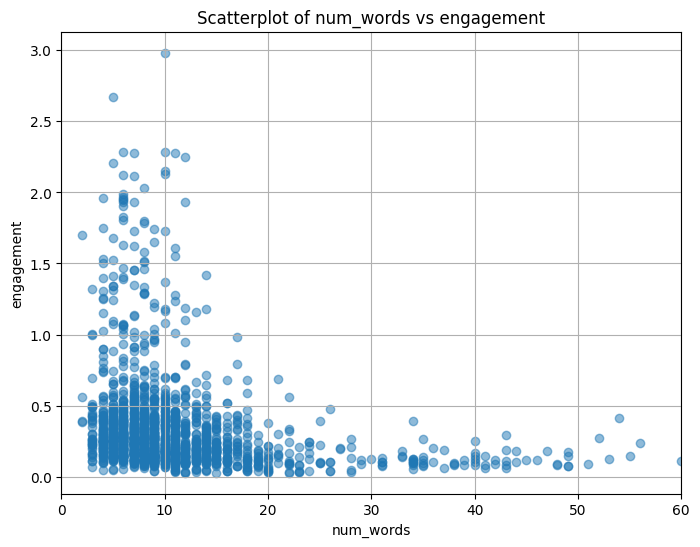

In [52]:
# Convert Spark DataFrame to Pandas DataFrame for plotting (assuming data size is manageable)
pandas_df = basetable_luf.select('num_words', 'engagement').toPandas()

# Scatterplot using Matplotlib
plt.figure(figsize=(8, 6))
plt.scatter(pandas_df['num_words'], pandas_df['engagement'], alpha=0.5)
plt.title('Scatterplot of num_words vs engagement')
plt.xlabel('num_words')
plt.ylabel('engagement')
plt.grid(True)
plt.xlim(0,60)
plt.show()

#### time_top_post

In [53]:
# Grouping and calculating metrics for basetable_luf by 'time_top_post_category'
grouped_time_luf = basetable_luf.groupBy('time_top_post').agg(
    F.avg(col('engagement')).alias('avg_engagement_luf'),
    F.stddev(col('engagement')).alias('stddev_engagement_luf'),
    avg(col('num_likes')).alias('avg_num_likes_luf'),
    avg(col('num_comments')).alias('avg_num_comments_luf')
).orderBy('time_top_post')

# Grouping and calculating metrics for basetable_sin by 'time_top_post_category'
grouped_time_sin = basetable_sin.groupBy('time_top_post').agg(
    avg(col('engagement')).alias('avg_engagement_sin'),
    F.stddev(col('engagement')).alias('stddev_engagement_sin'),
    avg(col('num_likes')).alias('avg_num_likes_sin'),
    avg(col('num_comments')).alias('avg_num_comments_sin')
).orderBy('time_top_post')


# Show results for basetable_luf and basetable_sin grouped by 'time_top_post_category'
grouped_time_luf.cache()
grouped_time_sin.cache()
grouped_time_luf.show()
grouped_time_sin.show

+-------------+-------------------+---------------------+------------------+--------------------+
|time_top_post| avg_engagement_luf|stddev_engagement_luf| avg_num_likes_luf|avg_num_comments_luf|
+-------------+-------------------+---------------------+------------------+--------------------+
|          0.0| 0.2804381828040944|   0.3609873547490826| 1148.251282051282|   6.112820512820512|
|          1.0| 0.2867183016045029|   0.2152654425908433|1660.1399286987523|   9.422459893048128|
|          2.0|0.37293077709995187|  0.35713171378350883|1766.6137184115523|  13.772563176895307|
|          3.0| 0.5539735758104283|   0.5938407516700849| 1946.676923076923|  15.092307692307692|
|          4.0| 0.5547667816142003|   0.5554372399616567|           950.375|             7.59375|
|          5.0|  0.880391940563286|   0.6964709054789618|1014.1666666666666|  10.866666666666667|
|          6.0| 0.7818044120779156|   0.7409032620305827| 674.2857142857143|   6.785714285714286|
|          7.0|  0.7

<bound method DataFrame.show of DataFrame[time_top_post: double, avg_engagement_sin: double, stddev_engagement_sin: double, avg_num_likes_sin: double, avg_num_comments_sin: double]>

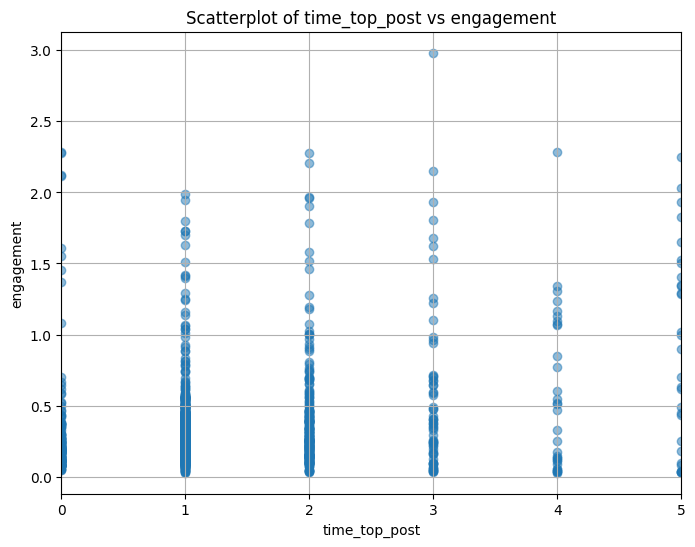

In [54]:
# Convert Spark DataFrame to Pandas DataFrame for plotting (assuming data size is manageable)
pandas_df = basetable_luf.select('time_top_post', 'engagement').toPandas()

# Scatterplot using Matplotlib
plt.figure(figsize=(8, 6))
plt.scatter(pandas_df['time_top_post'], pandas_df['engagement'], alpha=0.5)
plt.title('Scatterplot of time_top_post vs engagement')
plt.xlabel('time_top_post')
plt.ylabel('engagement')
plt.grid(True)
plt.xlim(0,5)
plt.show()

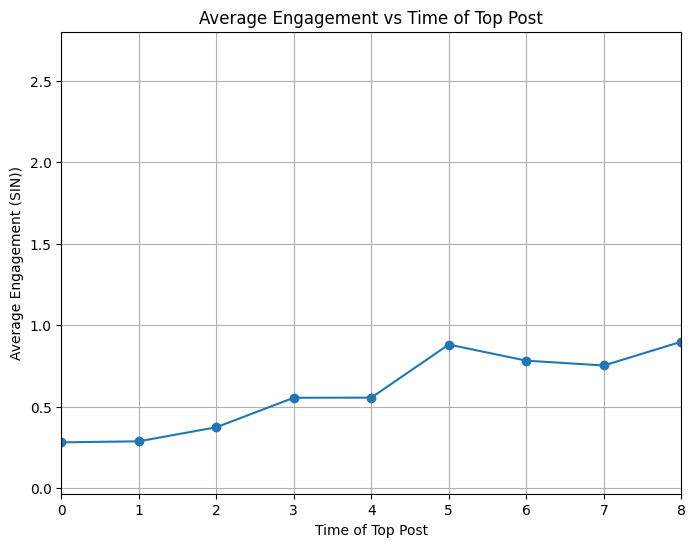

In [55]:
grouped_time_luf_pd = grouped_time_luf.toPandas()

# Sorting the Pandas DataFrame by 'time_top_post_category'
grouped_time_luf_pd = grouped_time_luf_pd.sort_values(by='time_top_post')

# Plotting 'time_top_post' vs 'avg_engagement_luf'
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(grouped_time_luf_pd['time_top_post'], grouped_time_luf_pd['avg_engagement_luf'], marker='o')
plt.title('Average Engagement vs Time of Top Post')
plt.xlabel('Time of Top Post')
plt.ylabel('Average Engagement (SIN))')
plt.xlim(0,8)
plt.grid(True)
plt.show()

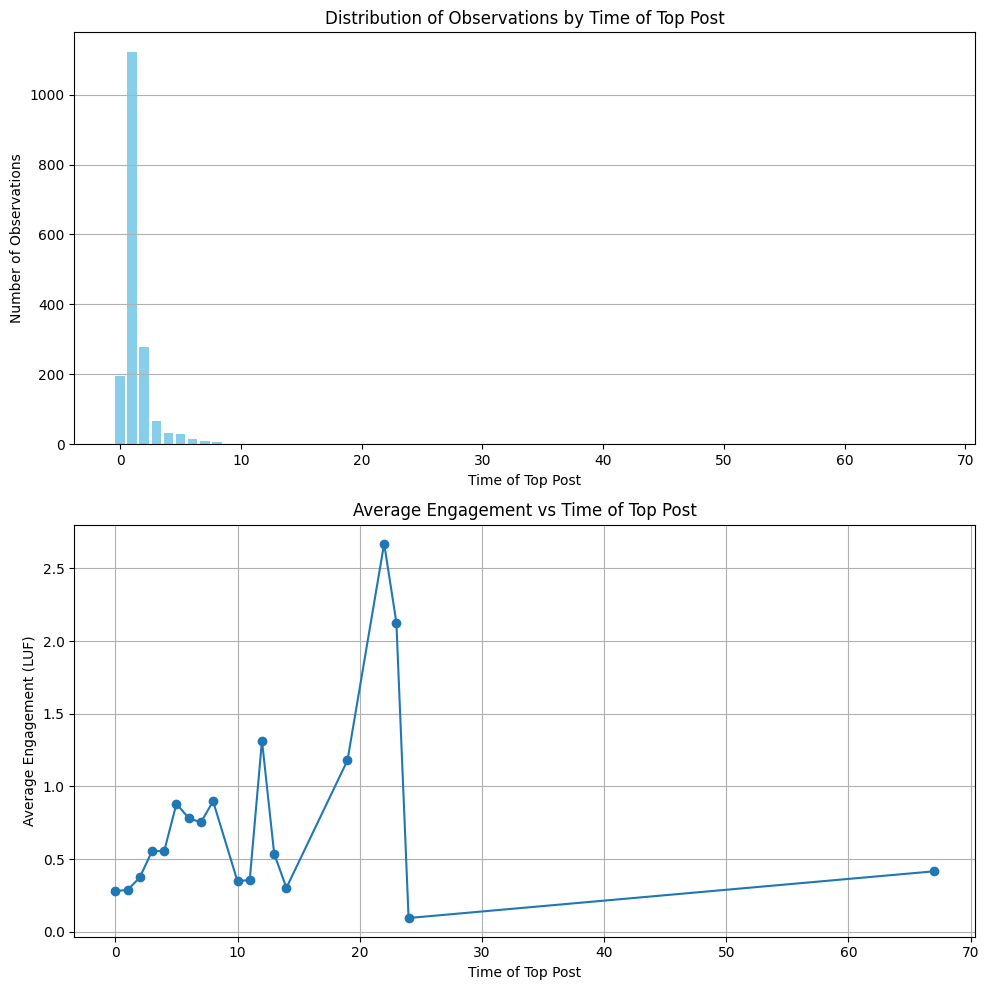

In [56]:
# Count the occurrences of each category
value_counts = luf_pd['time_top_post'].value_counts()

# Create a figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# Plotting distribution of observations above the graph
ax1.bar(value_counts.index, value_counts.values, color='skyblue')
ax1.set_title('Distribution of Observations by Time of Top Post')
ax1.set_xlabel('Time of Top Post')
ax1.set_ylabel('Number of Observations')
ax1.grid(axis='y')

# Plotting 'time_top_post' vs 'avg_engagement_luf' below the distribution
ax2.plot(grouped_time_luf_pd['time_top_post'], grouped_time_luf_pd['avg_engagement_luf'], marker='o')
ax2.set_title('Average Engagement vs Time of Top Post')
ax2.set_xlabel('Time of Top Post')
ax2.set_ylabel('Average Engagement (LUF)')
ax2.grid(True)

# Adjust layout for better visualization
plt.tight_layout()

# Show the plot
plt.show()

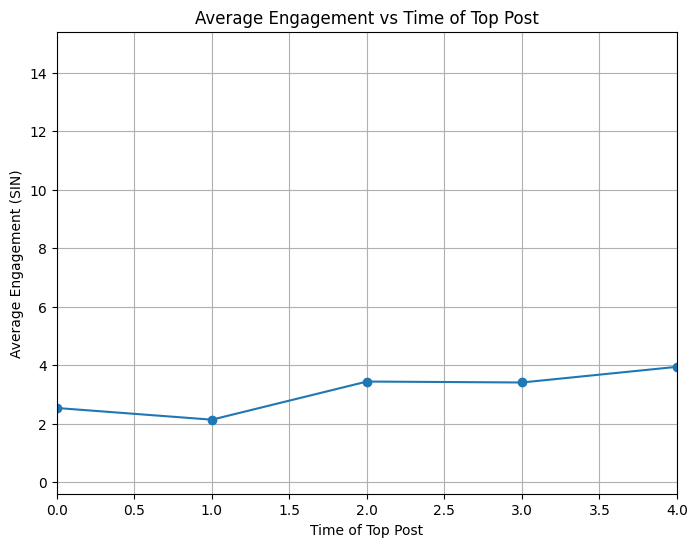

In [57]:
grouped_time_luf_sin = grouped_time_sin.toPandas()

# Sorting the Pandas DataFrame by 'time_top_post_category'
grouped_time_luf_sin = grouped_time_luf_sin.sort_values(by='time_top_post')

# Plotting 'time_top_post' vs 'avg_engagement_luf'
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(grouped_time_luf_sin['time_top_post'], grouped_time_luf_sin['avg_engagement_sin'], marker='o')
plt.title('Average Engagement vs Time of Top Post')
plt.xlabel('Time of Top Post')
plt.ylabel('Average Engagement (SIN)')
plt.xlim(0,4)
plt.grid(True)
plt.show()

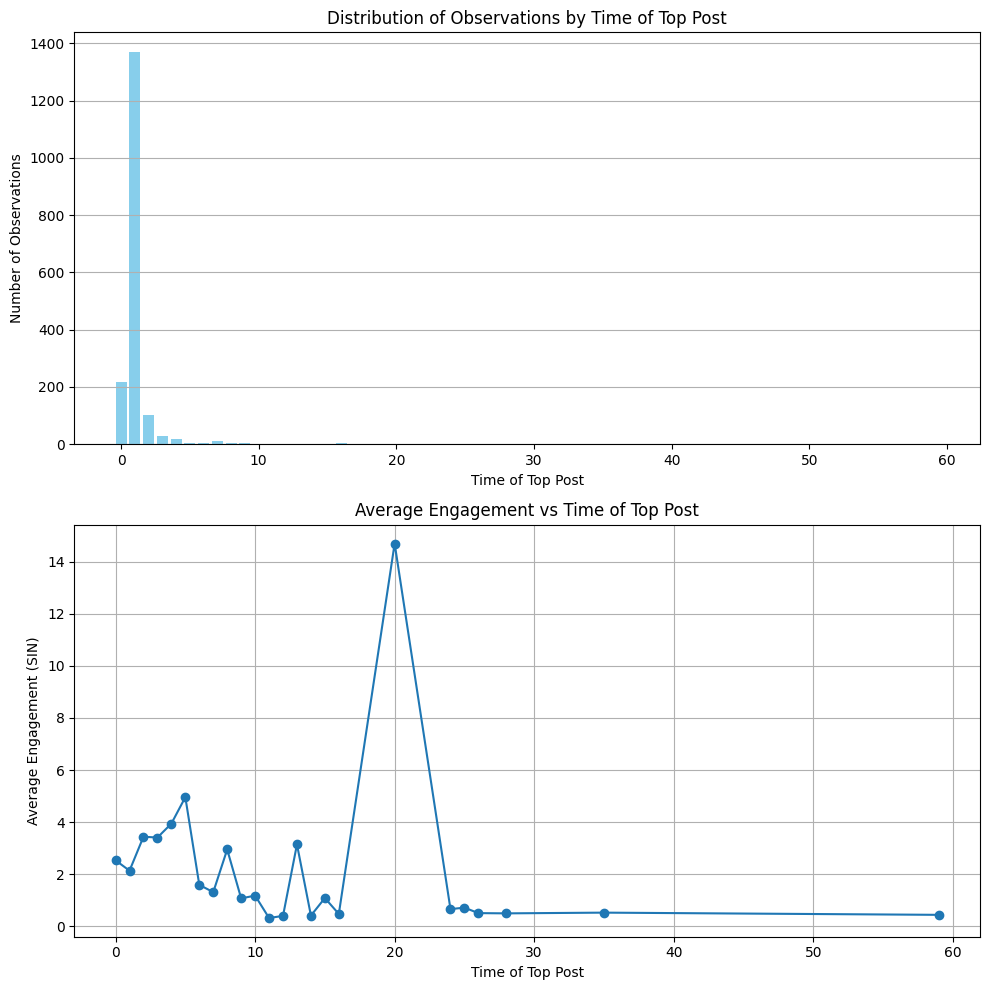

In [58]:
# Count the occurrences of each category
value_counts = sin_pd['time_top_post'].value_counts()

# Create a figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# Plotting distribution of observations above the graph
ax1.bar(value_counts.index, value_counts.values, color='skyblue')
ax1.set_title('Distribution of Observations by Time of Top Post')
ax1.set_xlabel('Time of Top Post')
ax1.set_ylabel('Number of Observations')
ax1.grid(axis='y')

# Plotting 'time_top_post' vs 'avg_engagement_luf' below the distribution
ax2.plot(grouped_time_luf_sin['time_top_post'], grouped_time_luf_sin['avg_engagement_sin'], marker='o')
ax2.set_title('Average Engagement vs Time of Top Post')
ax2.set_xlabel('Time of Top Post')
ax2.set_ylabel('Average Engagement (SIN)')
ax2.grid(True)

# Adjust layout for better visualization
plt.tight_layout()

# Show the plot
plt.show()

In [59]:
# Grouping and calculating metrics for basetable_luf by 'face_count'
grouped_face_luf = basetable_luf.groupBy('face_count').agg(
    F.avg(col('engagement')).alias('avg_engagement_luf'),
    F.stddev(col('engagement')).alias('stddev_engagement_luf'),
    avg(col('num_likes')).alias('avg_num_likes_luf'),
    avg(col('num_comments')).alias('avg_num_comments_luf')
).orderBy('face_count')

# Grouping and calculating metrics for basetable_sin by 'face_count'
grouped_face_sin = basetable_sin.groupBy('face_count').agg(
    avg(col('engagement')).alias('avg_engagement_sin'),
    F.stddev(col('engagement')).alias('stddev_engagement_sin'),
    avg(col('num_likes')).alias('avg_num_likes_sin'),
    avg(col('num_comments')).alias('avg_num_comments_sin')
).orderBy('face_count')

# Show results for basetable_luf and basetable_sin grouped by 'face_count'
grouped_face_luf.cache()
grouped_face_sin.cache()
grouped_face_luf.show()
grouped_face_sin.show()

+----------+-------------------+---------------------+------------------+--------------------+
|face_count| avg_engagement_luf|stddev_engagement_luf| avg_num_likes_luf|avg_num_comments_luf|
+----------+-------------------+---------------------+------------------+--------------------+
|       0.0| 0.3658157025690449|  0.35736975603156806|1633.4123947972455|  10.470543228768172|
|       1.0|0.24023612223733437|  0.26010403826021233| 1478.857142857143|   8.091575091575091|
|       2.0|0.29001568875079464|   0.3519821402985383|1361.5222222222221|   8.311111111111112|
|       3.0|0.19325857137291932|  0.08819808463943506|            1304.0|    8.03225806451613|
|       4.0|  0.201061371826799|   0.1282645224510093|            1224.0|                7.55|
|       5.0|0.20759249127371263|  0.10163048416451381|            1419.0|                11.0|
|       6.0| 0.3435718486495688|  0.32071186485090186|            1545.8|                 9.6|
|       7.0| 0.2900651943946498|  0.30910157117109

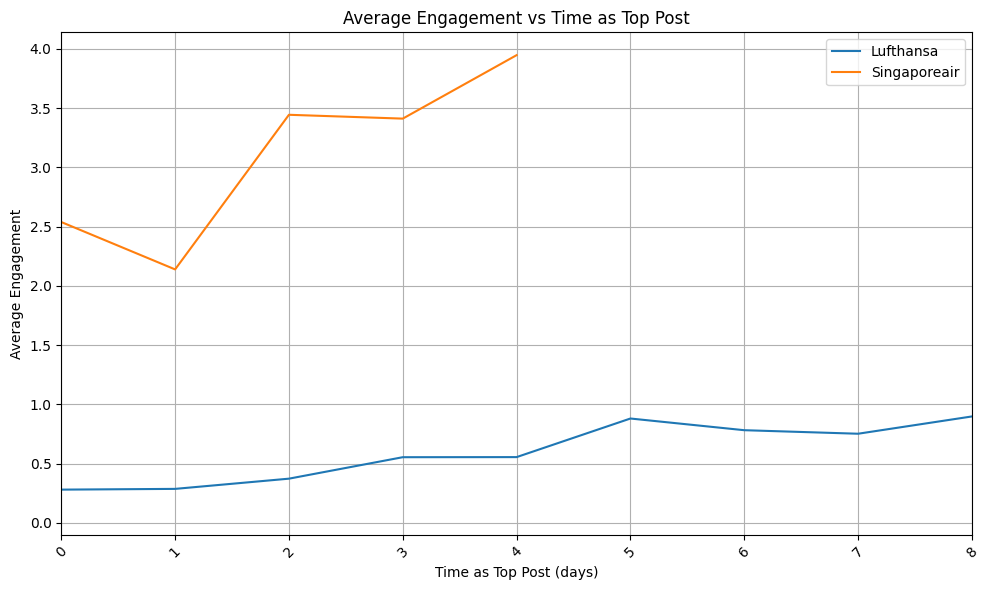

In [60]:
# Grouping and calculating metrics for basetable_luf by 'time_top_post'
grouped_time_luf = basetable_luf.groupBy('time_top_post').agg(
    F.avg('engagement').alias('avg_engagement_luf')
).orderBy('time_top_post')

# Grouping and calculating metrics for basetable_sin by 'time_top_post'
grouped_time_sin = basetable_sin.groupBy('time_top_post').agg(
    F.avg('engagement').alias('avg_engagement_sin')
).orderBy('time_top_post')

# Convert Spark DataFrames to Pandas DataFrames
df_luf = grouped_time_luf.toPandas()
df_sin = grouped_time_sin.toPandas()

# Plotting 'time_top_post' vs 'engagement' for basetable_luf and basetable_sin
plt.figure(figsize=(10, 6))

# Plot for basetable_luf
plt.plot(df_luf['time_top_post'], df_luf['avg_engagement_luf'], label='Lufthansa')

# Plot for basetable_sin
plt.plot(df_sin['time_top_post'][df_sin['time_top_post'] <= 4], df_sin['avg_engagement_sin'][df_sin['time_top_post'] <= 4], label='Singaporeair')

# Set x-axis limit for basetable_luf and basetable_sin
plt.xlim(0, 8)

plt.xlabel('Time as Top Post (days)')
plt.ylabel('Average Engagement')
plt.title('Average Engagement vs Time as Top Post')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

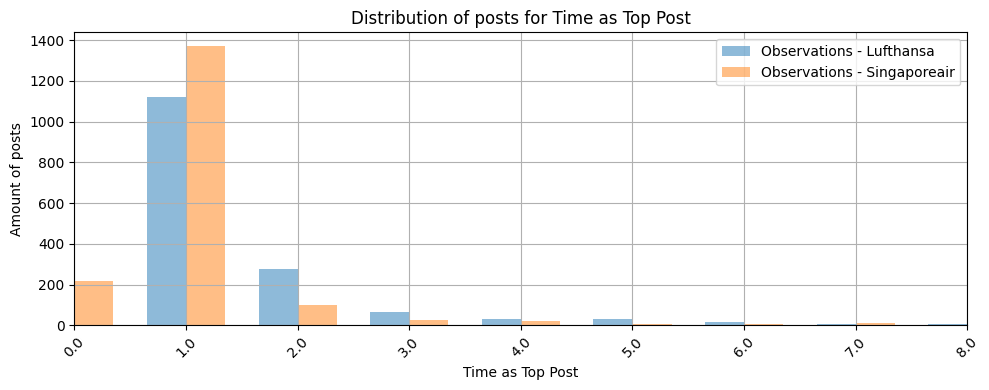

In [61]:
# Get distribution of observations for each value of 'time_top_post' for basetable_luf and basetable_sin
distribution_luf = basetable_luf.groupBy('time_top_post').count().orderBy('time_top_post').toPandas()
distribution_sin = basetable_sin.groupBy('time_top_post').count().orderBy('time_top_post').toPandas()

# Merge the two distributions based on 'time_top_post' values
merged_distribution = distribution_luf.merge(distribution_sin, on='time_top_post', how='outer').fillna(0)

# Define the x-axis positions for the bars
x = np.arange(len(merged_distribution['time_top_post']))

# Define the width of the bars
bar_width = 0.35

# Plotting distribution of observations for 'time_top_post' for basetable_luf and basetable_sin
plt.figure(figsize=(10, 4))

# Plot for basetable_luf
plt.bar(x - bar_width/2, merged_distribution['count_x'], bar_width, alpha=0.5, label='Observations - Lufthansa')

# Plot for basetable_sin
plt.bar(x + bar_width/2, merged_distribution['count_y'], bar_width, alpha=0.5, label='Observations - Singaporeair')

# Set x-axis labels
plt.xlabel('Time as Top Post')
plt.ylabel('Amount of posts')
plt.title('Distribution of posts for Time as Top Post')
plt.xticks(x, merged_distribution['time_top_post'], rotation=45)
plt.legend()
plt.xlim(0,8)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

#### face_count

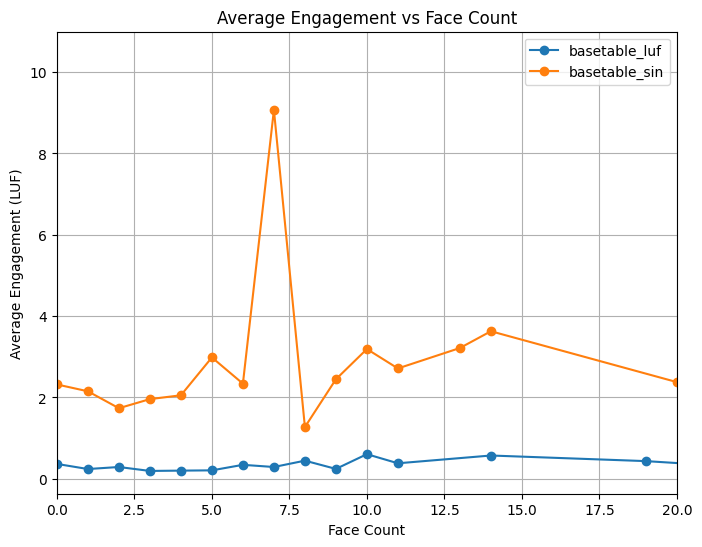

In [62]:
# Convert Spark DataFrames to Pandas DataFrames
grouped_face_luf_pd = grouped_face_luf.toPandas()
grouped_face_sin_pd = grouped_face_sin.toPandas()

# Plotting 'face_count' vs 'avg_engagement_luf' for basetable_luf
plt.figure(figsize=(8, 6))
plt.plot(grouped_face_luf_pd['face_count'], grouped_face_luf_pd['avg_engagement_luf'], marker='o', label='basetable_luf')
plt.title('Average Engagement vs Face Count')
plt.xlabel('Face Count')
plt.xlim(0,20)
plt.ylabel('Average Engagement (LUF)')
plt.grid(True)

# Plotting 'face_count' vs 'avg_engagement_sin' for basetable_sin on the same plot
plt.plot(grouped_face_sin_pd['face_count'], grouped_face_sin_pd['avg_engagement_sin'], marker='o', label='basetable_sin')
plt.legend()  # Show legend to differentiate between the lines

# Show the plot
plt.show()

#### vividness

In [63]:
# Grouping and calculating metrics for basetable_luf by 'vividness'
grouped_vividness_luf = basetable_luf.groupBy('vividness').agg(
    F.avg(col('engagement')).alias('avg_engagement_luf'),
    F.stddev(col('engagement')).alias('stddev_engagement_luf'),
    avg(col('num_likes')).alias('avg_num_likes_luf'),
    avg(col('num_comments')).alias('avg_num_comments_luf')
)

# Grouping and calculating metrics for basetable_sin by 'vividness'
grouped_vividness_sin = basetable_sin.groupBy('vividness').agg(
    avg(col('engagement')).alias('avg_engagement_sin'),
    F.stddev(col('engagement')).alias('stddev_engagement_sin'),
    avg(col('num_likes')).alias('avg_num_likes_sin'),
    avg(col('num_comments')).alias('avg_num_comments_sin')
)

# Show results for basetable_luf and basetable_sin grouped by 'vividness'
grouped_vividness_luf.cache()
grouped_vividness_sin.cache()
grouped_vividness_luf.show()
grouped_vividness_sin.show()

+---------+-------------------+---------------------+------------------+--------------------+
|vividness| avg_engagement_luf|stddev_engagement_luf| avg_num_likes_luf|avg_num_comments_luf|
+---------+-------------------+---------------------+------------------+--------------------+
|     High|0.13750805995243007|  0.13823110665195434| 990.1550387596899|   8.852713178294573|
|      Low|  0.352531794683574|   0.3476897611759648|1631.8438844499078|  10.013521819299324|
|   Medium| 0.2162470627242355|  0.06301451051003447|            2013.0|                15.4|
+---------+-------------------+---------------------+------------------+--------------------+

+---------+------------------+---------------------+-----------------+--------------------+
|vividness|avg_engagement_sin|stddev_engagement_sin|avg_num_likes_sin|avg_num_comments_sin|
+---------+------------------+---------------------+-----------------+--------------------+
|     High|1.8143438824719502|   2.0557869538037257|5300.15544041